In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

from altaipony.flarelc import FlareLightCurve
from altaipony.fakeflares import aflare
from altaipony.altai import find_iterative_median

from astropy.constants import R_sun
import astropy.units as u

import os
import copy

import numpy as np
import pandas as pd

#from funcs.custom_detrending import custom_detrending, iteratively_remove_sines
from funcs.funcs import read_custom_aperture_lc
from funcs.multiperiod import remove_sinusoidal, fetch_lightcurve
from funcs.flarefit import aflare2
from funcs.model import big_model, calculate_specific_flare_flux

#import astropy.units as u

from scipy import optimize
from scipy.misc import derivative

CWD = "/".join(os.getcwd().split("/")[:-2])

import warnings
warnings.simplefilter("ignore")

import pytest

/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [2]:
lcs = pd.read_csv(f"{CWD}/data/summary/lcs.csv")
guesses = pd.read_csv(f"{CWD}/data/summary/results.csv")
lcs

,ID,QCS,typ,cadence_min,mission,prefix,origin,h_mission,SpT,view_start,...,J,R,Gaia_G,vsini_kms,e_vsini_kms,Prot_d,sini,Ref,identifier,Rstar
0,100004076,14,slc,1,kep,KIC,generic,Kepler,L1,1356.50,...,13.078,NaN,17.8356,11.2,2.2,0.37015,>.59,Gizis+13,WISEP J190648.47+401106.8,0.107
1,212035340,18,llc,30,ktwo,EPIC,generic,K2,M8,3437.00,...,15.900,NaN,19.5667,30.0,12.0,0.19300,NaN,Paudel+19,MASS J08371832+2050349,0.111
2,237880881,1,slc,2,tess,TIC,generic,TESS,M5,1331.00,...,11.530,NaN,14.9796,14.4,2.6,0.35125,NaN,Kraus+14,2MASS J01180670-6258591,0.199
3,44984200,10,slc,2,tess,TIC,custom,TESS,M6,1587.25,...,10.309,15.08,14.4115,NaN,NaN,0.11300,NaN,this work,SCR J0838-5855,NaN
4,277539431,12,slc,2,tess,TIC,custom,TESS,M7,1641.00,...,10.630,NaN,14.7381,NaN,NaN,0.19000,NaN,this work,WISEA J105515.71-735611.3,NaN
5,300741820,8,slc,2,tess,TIC,generic,TESS,NaN,1522.00,...,11.959,NaN,15.3277,NaN,NaN,0.13200,NaN,Zhan+19,UCAC4 116-015389,NaN


In [3]:
v_rot = lcs['Rstar'].values*2*np.pi*R_sun / (lcs['Prot_d'].values*u.d)
vsini = (lcs['vsini_kms']-lcs['e_vsini_kms']).values*u.km/u.s
e_vsini = lcs['e_vsini_kms'].values*u.km/u.s
sini = (vsini / v_rot ).decompose()
print(sini.decompose(), v_rot.to("km/s"))
# set values larger than 1 to 1 (must be due to uncertainties in Rstar or vsini):
sini[sini.decompose() > 1] = 1.
print(sini.decompose())
incl = np.arcsin(sini.decompose())
print(vsini/v_rot)
lcs["incl"] = incl
lcs["incl_err"] = e_vsini / (v_rot * np.sqrt(1. - sini**2))
lcs.loc[1,"incl"]


[0.61538705 0.61861252 0.4116775         nan        nan        nan] [14.62494203 29.09737419 28.66321312         nan         nan         nan] km / s
[0.61538705 0.61861252 0.4116775         nan        nan        nan]
[7.12253536e-09 7.15986714e-09 4.76478591e-09            nan
            nan            nan] d km / (m s)


0.6669755499675769

In [4]:
guesses

,ID,ED,e_ED,t0,e_t0,dur,e_dur,ampl,e_ampl,Prot
0,TIC 237880881,6020,298,1331.82418,0.00194,0.77347,0.02975,0.46626,0.01576,8.43
1,KIC 100004076,10414,886,1358.52754,0.00072,0.49377,0.02388,0.79166,0.06277,8.88
2,TIC 44984200,3809,135,1588.02740,0.00106,0.65066,0.03073,0.29153,0.00868,2.71
3,TIC 277539431,4495,394,1641.86831,0.00291,0.89720,0.08459,0.35356,0.03025,4.56
4,EPIC 212035340,1954494,483655,3437.83750,0.00029,0.05795,0.00631,298.07702,42.06769,4.63


In [5]:
target = lcs.loc[1]
guess = guesses.loc[4]
target, guess

(ID                           212035340
 QCS                                 18
 typ                                llc
 cadence_min                         30
 mission                           ktwo
 prefix                            EPIC
 origin                         generic
 h_mission                           K2
 SpT                                 M8
 view_start                        3437
 view_stop                       3439.5
 view_min                           100
 view_max                           900
 BJDoff                         2454833
 tstart                         3437.75
 ampl_min                           NaN
 ampl_max                           NaN
 RA                             129.326
 Dec                             20.843
 J                                 15.9
 R                                  NaN
 Gaia_G                         19.5667
 vsini_kms                           30
 e_vsini_kms                         12
 Prot_d                           0.193


### Load the light curve and find the median flux and standard deviation to get a sense for the noise

5% (119/2490) of the cadences will be ignored due to the quality mask (quality_bitmask=1130799).
5% (119/2490) of the cadences will be ignored due to the quality mask (quality_bitmask=1130799).
5% (119/2490) of the cadences will be ignored due to the quality mask (quality_bitmask=1130799).
5% (119/2490) of the cadences will be ignored due to the quality mask (quality_bitmask=1130799).
5% (119/2490) of the cadences will be ignored due to the quality mask (quality_bitmask=1130799).
5% (119/2490) of the cadences will be ignored due to the quality mask (quality_bitmask=1130799).


EPIC 212035340 modulation period:  4.625968870015097 h
Relative amplitude of modulation: 5.5e-02


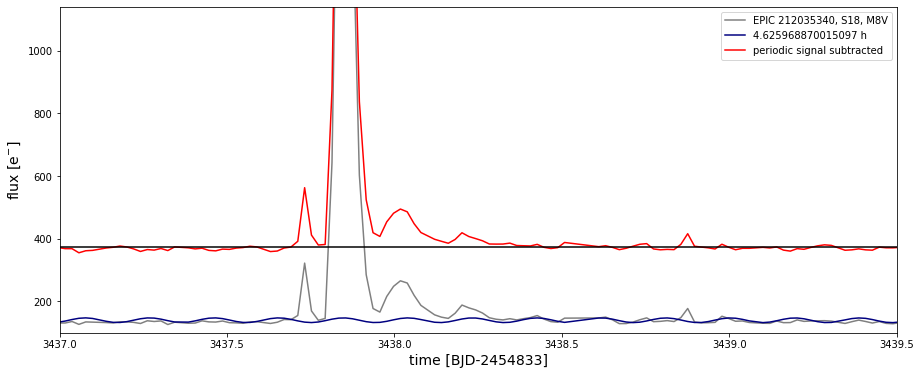

In [6]:
flck = fetch_lightcurve(target)

t, sflux, model, period = remove_sinusoidal(target, plot=True, save=True)

### Modify data: map time to longitude, subtract sinusoidal

<ErrorbarContainer object of 3 artists>

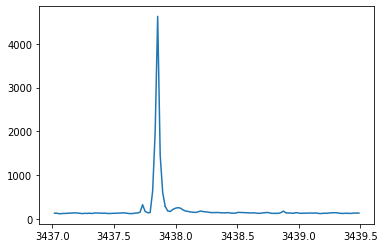

In [7]:
choice = (t > target.view_start) & (t < target.view_stop)
t = t[choice]
flux = sflux[choice]
flux_err = np.mean(flck.flux_err)
plt.errorbar(x=t, y=flux, yerr=flux_err)


<ErrorbarContainer object of 3 artists>

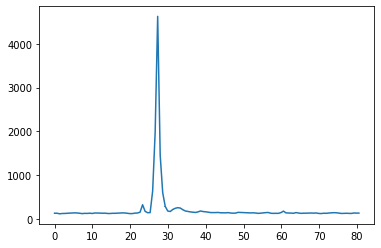

In [8]:
phi = (t - t[0])/target.Prot_d * 2 * np.pi

plt.errorbar(x=phi, y=flux, yerr=flux_err)

## Define likelihoods

In [9]:
#inclination has an uncertainty from Vsin i measurement, give it a gauss
i_mu, i_sigma = np.pi/2, np.pi/2-0.6669755499675769
# the maximum of the flux +/- one period should be right
phi_a_min, phi_a_max = 0, 2*np.pi
# latitude should be 0 - 90
theta_a_min, theta_a_max = 0, np.pi/2
# amplitude and fwhm must be positive
a_min, a_max, fwhm_min, fwhm_max = 0, 1e9, 0, 1e10

theta_err = (i_mu, i_sigma, phi_a_min, phi_a_max, theta_a_min, theta_a_max, a_min, a_max, fwhm_min, fwhm_max)

In [32]:
def logit(function):
    '''Make a probability distribution
    a log probability distribution.'''
    def wrapper(*args, **kwargs):
        result = function(*args, **kwargs)
        np.seterr(divide='ignore') # ignore division by zero because you want to have the -np.inf results
        result = np.log(result)
        return result
    return wrapper

@logit
def uninformative_prior(rate, minrate, maxrate):
    '''Uninformative prior for the rates.
    Uniform within [minrate, maxrate].

    Parameters:
    -------------
    rate : float

    minrate, maxrate : float
        interval in which rate is constrained

    Return:
        Prior probability
    '''
    if ((rate >= minrate) & (rate <= maxrate)):
        return 1. / (maxrate - minrate)
    else:
        return 0
    
@logit
def gaussian_prior(x, mu, sigma):
    '''Evaluate a normalized Gaussian function
    with mu and sigma at x. NOT TESTED.'''
    if x > np.pi/2:
        return 0
    else:
        return  1 / (sigma * np.sqrt(2 * np.pi)) * np.exp( - (x - mu)**2 / (2 * sigma**2))


def calculate_posterior_value_that_can_be_passed_to_mcmc(lp):
    '''Do some checks to make sure MCMC will work. NOT TESTED.'''
    if not np.isfinite(lp):
        return -np.inf
    if np.isnan(lp):
        return -np.inf
    else:
        return lp

def log_prior(theta, theta_err):
    """Uniform prior for start time,
    amplitude, and duration.
    
    - Start time shoud lie approximately 
      within the observation time.
    - Duration always positive.
    - Amplitude always positive.
    
    Parameters:
    ------------
    theta : tuple
        start time, duration, amplitude
    x : array
        time array to constrain start time
    """
    phi_a, theta_a, a, fwhm, i =  theta
    i_mu, i_sigma, phi_a_min, phi_a_max, theta_a_min, theta_a_max, a_min, a_max, fwhm_min, fwhm_max

#     prior = (logit(gaussian_prior(i, i_mu, i_sigma)) +
#              logit(uninformative_prior(phi_a, phi_a_min, phi_a_max)) + 
#              logit(uninformative_prior(theta_a, theta_a_min, theta_a_max)) + 
#              logit(uninformative_prior(a, a_min, a_max)) + 
#              logit(uninformative_prior(fwhm, fwhm_min, fwhm_max)))

    prior = (gaussian_prior(i, i_mu, i_sigma) +
             uninformative_prior(phi_a, phi_a_min, phi_a_max) + 
             uninformative_prior(theta_a, theta_a_min, theta_a_max) + 
             uninformative_prior(a, a_min, a_max) + 
             uninformative_prior(fwhm, fwhm_min, fwhm_max))
    
    return calculate_posterior_value_that_can_be_passed_to_mcmc(prior)
             
            

In [33]:
def log_likelihood(theta, phi, flux, flux_err, qlum, Fth, R, median ):
    """Log likelihood function assuming 
    Gaussian uncertainties in the data points.
    SHOULDNT THIS BE POISSON?
    """
    
    phi_a, theta_a, a, fwhm, i = theta
    model = big_model(phi_a, theta_a, a, fwhm, i, phi0=0,
                      phi=phi, num_pts=100, qlum=qlum,
                      Fth=Fth, R=R, median=median)
    val = -0.5 * np.sum((flux - model) ** 2 / flux_err**2 + np.log(flux_err**2))
    return val

def log_probability(theta, phi, flux, flux_err, qlum, Fth, R, median, theta_err):
    """Posterior probability to pass to MCMC sampler.
    """
    lp = log_prior(theta, theta_err)
    
    if not np.isfinite(lp):
        print("HO")
        return -np.inf
    try:
        ll = log_likelihood(theta, phi, flux, flux_err, qlum, Fth, R, median)
    except:
        return -np.inf
    if np.isnan(ll):
        return -np.inf
    return lp + ll

## Set up model

In [34]:
# constants
qlum = 3.2323579e30 * u.erg/ u.s
Fth = calculate_specific_flare_flux(mission="Kepler",flaret=1e4) 
R = 0.115204*R_sun
#flc = FlareLightCurve(time=flck.time, flux=flck.flux, flux_err=flck.flux_err,
#                     detrended_flux=flck.flux, detrended_flux_err=flck.flux_err)
median = np.nanmean(flck.flux)

# numerical parameters
num_pts = 100

# model parameters
theta_a, phi_a = (45*np.pi/180, np.pi)
i = 89 * np.pi / 180
i_mu = i
i_sigma = 20 * np.pi / 180
a = 10
fwhm = guess.dur/target.Prot_d * 2 * np.pi # two periods

# time series
phi0 = 0 #is this correct offset?
#phi = np.linspace(phi0,6*np.pi+phi0,1e3)

# model steps
print(phi_a, phi_a_min, phi_a_max, "\n",
      theta_a, theta_a_min, theta_a_max, "\n",
      a,  a_min, a_max, "\n",
      fwhm, fwhm_min, fwhm_max,"\n",
      i, i_mu, i_sigma)

Fth

3.141592653589793 0 6.283185307179586 
 0.7853981633974483 0 1.5707963267948966 
 10 0 1000000000.0 
 1.8865833603681712 0 10000000000.0 
 1.5533430342749535 1.5533430342749535 0.3490658503988659


## Run MCMC

In [35]:
import emcee

pos = np.array([phi_a, theta_a, a, fwhm, i]) + 1e-4 * np.random.randn(32, 5)
#pos = initial + 1e-4 * np.random.randn(32, 3)
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability,
                                args=(phi, flux, flux_err, qlum, Fth, R, median, theta_err))
sampler.run_mcmc(pos, 2000, progress=True);

  1%|▏         | 27/2000 [00:04<06:33,  5.02it/s]

HO
HO


  1%|▏         | 28/2000 [00:05<06:40,  4.93it/s]

HO


  2%|▏         | 30/2000 [00:05<06:24,  5.12it/s]

HO
HO
HO


  2%|▏         | 31/2000 [00:05<06:25,  5.11it/s]

HO
HO


  2%|▏         | 35/2000 [00:06<06:20,  5.16it/s]

HO
HO
HO
HO


  2%|▏         | 36/2000 [00:06<06:22,  5.14it/s]

HO
HO
HO


  2%|▏         | 37/2000 [00:06<06:22,  5.13it/s]

HO


  2%|▏         | 40/2000 [00:07<06:27,  5.06it/s]

HO
HO
HO


  2%|▏         | 41/2000 [00:07<06:19,  5.16it/s]

HO
HO
HO
HO


  2%|▏         | 43/2000 [00:08<06:15,  5.21it/s]

HO
HO
HO
HO
HO
HO


  2%|▏         | 44/2000 [00:08<06:13,  5.24it/s]

HO
HO
HO
HO


  2%|▏         | 45/2000 [00:08<06:14,  5.23it/s]

HO
HO
HO


  2%|▏         | 46/2000 [00:08<06:19,  5.16it/s]

HO
HO


  2%|▏         | 47/2000 [00:08<06:31,  4.99it/s]

HO
HO
HO
HO


  2%|▏         | 49/2000 [00:09<06:17,  5.17it/s]

HO
HO
HO
HO


  2%|▎         | 50/2000 [00:09<06:06,  5.32it/s]

HO
HO
HO
HO
HO
HO
HO


  3%|▎         | 51/2000 [00:09<06:11,  5.25it/s]

HO
HO
HO
HO
HO
HO


  3%|▎         | 53/2000 [00:09<06:06,  5.31it/s]

HO
HO
HO


  3%|▎         | 54/2000 [00:10<06:02,  5.37it/s]

HO
HO
HO
HO


  3%|▎         | 56/2000 [00:10<06:16,  5.17it/s]

HO
HO
HO
HO


  3%|▎         | 58/2000 [00:10<06:16,  5.16it/s]

HO
HO
HO
HO


  3%|▎         | 59/2000 [00:11<06:24,  5.05it/s]

HO
HO
HO
HO
HO


  3%|▎         | 60/2000 [00:11<06:31,  4.96it/s]

HO
HO


  3%|▎         | 62/2000 [00:11<06:39,  4.85it/s]

HO
HO
HO
HO


  3%|▎         | 63/2000 [00:11<06:39,  4.85it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO


  3%|▎         | 65/2000 [00:12<06:21,  5.07it/s]

HO
HO
HO
HO
HO
HO
HO


  3%|▎         | 67/2000 [00:12<06:06,  5.27it/s]

HO
HO
HO
HO
HO
HO
HO
HO


  3%|▎         | 68/2000 [00:12<05:55,  5.43it/s]

HO
HO


  3%|▎         | 69/2000 [00:13<06:03,  5.31it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO


  4%|▎         | 70/2000 [00:13<05:55,  5.42it/s]

HO
HO
HO


  4%|▎         | 72/2000 [00:13<06:03,  5.30it/s]

HO
HO
HO
HO
HO
HO


  4%|▎         | 73/2000 [00:13<06:11,  5.19it/s]

HO
HO
HO
HO


  4%|▎         | 74/2000 [00:14<06:20,  5.06it/s]

HO
HO
HO
HO
HO


  4%|▍         | 75/2000 [00:14<06:23,  5.02it/s]

HO
HO
HO
HO
HO
HO
HO


  4%|▍         | 77/2000 [00:14<06:17,  5.10it/s]

HO
HO
HO


  4%|▍         | 78/2000 [00:14<06:01,  5.32it/s]

HO
HO
HO
HO


  4%|▍         | 80/2000 [00:15<06:10,  5.19it/s]

HO
HO


  4%|▍         | 82/2000 [00:15<05:48,  5.50it/s]

HO
HO
HO
HO
HO
HO


  4%|▍         | 83/2000 [00:15<06:00,  5.31it/s]

HO
HO
HO
HO
HO


  4%|▍         | 84/2000 [00:16<06:20,  5.03it/s]

HO
HO
HO
HO


  4%|▍         | 86/2000 [00:16<06:09,  5.18it/s]

HO
HO
HO
HO


  4%|▍         | 88/2000 [00:16<06:09,  5.17it/s]

HO
HO
HO
HO
HO


  4%|▍         | 89/2000 [00:17<06:14,  5.10it/s]

HO
HO
HO
HO


  5%|▍         | 91/2000 [00:17<05:52,  5.42it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


  5%|▍         | 93/2000 [00:17<06:07,  5.19it/s]

HO


  5%|▍         | 94/2000 [00:17<06:04,  5.22it/s]

HO
HO
HO
HO
HO


  5%|▍         | 95/2000 [00:18<05:55,  5.36it/s]

HO
HO
HO
HO
HO
HO
HO


  5%|▍         | 97/2000 [00:18<06:04,  5.22it/s]

HO
HO


  5%|▍         | 98/2000 [00:18<06:07,  5.18it/s]

HO
HO
HO
HO
HO
HO
HO


  5%|▍         | 99/2000 [00:18<06:04,  5.22it/s]

HO
HO
HO
HO


  5%|▌         | 101/2000 [00:19<05:37,  5.63it/s]

HO
HO
HO
HO
HO
HO
HO
HO


  5%|▌         | 102/2000 [00:19<05:41,  5.55it/s]

HO
HO
HO
HO
HO
HO
HO


  5%|▌         | 104/2000 [00:19<05:47,  5.46it/s]

HO
HO
HO
HO
HO
HO
HO


  5%|▌         | 105/2000 [00:20<06:16,  5.03it/s]

HO
HO


  5%|▌         | 106/2000 [00:20<06:03,  5.21it/s]

HO
HO
HO


  5%|▌         | 108/2000 [00:20<06:10,  5.11it/s]

HO
HO
HO
HO
HO


  5%|▌         | 109/2000 [00:20<06:08,  5.13it/s]

HO
HO
HO


  6%|▌         | 110/2000 [00:20<06:08,  5.14it/s]

HO
HO
HO
HO
HO


  6%|▌         | 111/2000 [00:21<06:20,  4.97it/s]

HO
HO
HO
HO
HO
HO
HO


  6%|▌         | 112/2000 [00:21<06:00,  5.24it/s]

HO
HO
HO
HO


  6%|▌         | 113/2000 [00:21<05:57,  5.28it/s]

HO
HO
HO


  6%|▌         | 115/2000 [00:21<06:03,  5.18it/s]

HO
HO
HO
HO
HO
HO


  6%|▌         | 116/2000 [00:22<05:53,  5.33it/s]

HO
HO
HO
HO
HO
HO


  6%|▌         | 117/2000 [00:22<06:18,  4.98it/s]

HO
HO


  6%|▌         | 118/2000 [00:22<06:13,  5.04it/s]

HO
HO


  6%|▌         | 120/2000 [00:22<06:08,  5.10it/s]

HO
HO
HO
HO
HO


  6%|▌         | 121/2000 [00:23<06:11,  5.06it/s]

HO
HO
HO
HO
HO
HO
HO


  6%|▌         | 122/2000 [00:23<05:56,  5.27it/s]

HO
HO
HO
HO


  6%|▌         | 123/2000 [00:23<05:58,  5.24it/s]

HO
HO


  6%|▌         | 124/2000 [00:23<06:11,  5.05it/s]

HO
HO
HO
HO
HO


  6%|▋         | 125/2000 [00:23<06:16,  4.98it/s]

HO
HO


  6%|▋         | 126/2000 [00:24<06:20,  4.92it/s]

HO
HO
HO
HO


  6%|▋         | 128/2000 [00:24<06:04,  5.13it/s]

HO
HO
HO
HO
HO


  6%|▋         | 129/2000 [00:24<06:17,  4.96it/s]

HO
HO
HO
HO
HO


  6%|▋         | 130/2000 [00:24<06:13,  5.01it/s]

HO
HO
HO


  7%|▋         | 132/2000 [00:25<06:12,  5.01it/s]

HO
HO
HO
HO
HO


  7%|▋         | 134/2000 [00:25<06:17,  4.94it/s]

HO
HO
HO
HO
HO
HO


  7%|▋         | 135/2000 [00:25<06:18,  4.93it/s]

HO
HO
HO
HO
HO


  7%|▋         | 136/2000 [00:26<06:10,  5.03it/s]

HO
HO
HO
HO
HO


  7%|▋         | 137/2000 [00:26<06:12,  5.00it/s]

HO
HO
HO
HO


  7%|▋         | 139/2000 [00:26<06:25,  4.83it/s]

HO
HO
HO


  7%|▋         | 140/2000 [00:26<06:13,  4.98it/s]

HO
HO
HO
HO
HO
HO


  7%|▋         | 142/2000 [00:27<06:04,  5.10it/s]

HO
HO
HO
HO


  7%|▋         | 143/2000 [00:27<06:18,  4.90it/s]

HO
HO


  7%|▋         | 144/2000 [00:27<06:20,  4.87it/s]

HO
HO
HO
HO
HO
HO


  7%|▋         | 145/2000 [00:27<06:14,  4.95it/s]

HO
HO
HO


  7%|▋         | 147/2000 [00:28<06:25,  4.81it/s]

HO
HO
HO


  7%|▋         | 148/2000 [00:28<06:13,  4.95it/s]

HO
HO
HO
HO
HO


  8%|▊         | 150/2000 [00:28<06:13,  4.95it/s]

HO
HO
HO
HO


  8%|▊         | 151/2000 [00:29<06:09,  5.00it/s]

HO
HO
HO
HO
HO


  8%|▊         | 152/2000 [00:29<06:10,  4.99it/s]

HO
HO


  8%|▊         | 153/2000 [00:29<06:19,  4.87it/s]

HO
HO


  8%|▊         | 154/2000 [00:29<06:24,  4.80it/s]

HO
HO
HO
HO
HO


  8%|▊         | 156/2000 [00:30<06:22,  4.82it/s]

HO
HO


  8%|▊         | 157/2000 [00:30<06:19,  4.86it/s]

HO
HO
HO
HO


  8%|▊         | 158/2000 [00:30<06:12,  4.94it/s]

HO
HO
HO
HO
HO
HO
HO


  8%|▊         | 159/2000 [00:30<06:05,  5.03it/s]

HO
HO
HO
HO
HO


  8%|▊         | 161/2000 [00:31<06:06,  5.02it/s]

HO
HO
HO
HO


  8%|▊         | 162/2000 [00:31<06:11,  4.94it/s]

HO
HO
HO
HO


  8%|▊         | 163/2000 [00:31<05:56,  5.16it/s]

HO
HO
HO
HO
HO


  8%|▊         | 164/2000 [00:31<05:57,  5.14it/s]

HO
HO
HO
HO


  8%|▊         | 165/2000 [00:32<06:09,  4.97it/s]

HO


  8%|▊         | 167/2000 [00:32<06:09,  4.96it/s]

HO
HO
HO
HO
HO


  8%|▊         | 168/2000 [00:32<06:05,  5.01it/s]

HO
HO
HO
HO
HO
HO


  8%|▊         | 170/2000 [00:32<05:49,  5.23it/s]

HO
HO
HO
HO
HO
HO
HO


  9%|▊         | 172/2000 [00:33<05:55,  5.14it/s]

HO
HO
HO
HO


  9%|▊         | 174/2000 [00:33<06:12,  4.91it/s]

HO
HO


  9%|▉         | 175/2000 [00:34<06:06,  4.99it/s]

HO
HO
HO
HO
HO
HO


  9%|▉         | 176/2000 [00:34<05:57,  5.10it/s]

HO
HO
HO
HO


  9%|▉         | 178/2000 [00:34<05:45,  5.27it/s]

HO
HO
HO
HO
HO
HO
HO


  9%|▉         | 179/2000 [00:34<05:55,  5.13it/s]

HO
HO
HO


  9%|▉         | 180/2000 [00:34<05:57,  5.09it/s]

HO
HO
HO
HO
HO
HO
HO


  9%|▉         | 182/2000 [00:35<05:45,  5.27it/s]

HO
HO
HO
HO
HO


  9%|▉         | 183/2000 [00:35<06:02,  5.01it/s]

HO
HO
HO


  9%|▉         | 185/2000 [00:35<06:00,  5.04it/s]

HO
HO
HO
HO
HO


  9%|▉         | 186/2000 [00:36<05:57,  5.08it/s]

HO
HO
HO
HO
HO
HO
HO


  9%|▉         | 187/2000 [00:36<06:02,  5.00it/s]

HO
HO


  9%|▉         | 189/2000 [00:36<05:52,  5.14it/s]

HO
HO
HO
HO
HO
HO


 10%|▉         | 190/2000 [00:36<05:54,  5.10it/s]

 32%|███▏      | 634/2000 [01:57<04:00,  5.69it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 32%|███▏      | 635/2000 [01:58<03:54,  5.81it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 32%|███▏      | 637/2000 [01:58<03:51,  5.89it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 32%|███▏      | 638/2000 [01:58<03:44,  6.07it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 32%|███▏      | 639/2000 [01:58<03:52,  5.84it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 32%|███▏      | 641/2000 [01:59<03:46,  6.00it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 32%|███▏      | 642/2000 [01:59<03:41,  6.13it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 32%|███▏      | 643/2000 [01:59<03:46,  5.99it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 32%|███▏      | 645/2000 [01:59<03:46,  5.98it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 32%|███▏      | 646/2000 [01:59<03:44,  6.03it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 32%|███▏      | 647/2000 [02:00<03:54,  5.77it/s]

HO
HO
HO
HO
HO
HO
HO
HO


 32%|███▏      | 648/2000 [02:00<04:01,  5.60it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 32%|███▎      | 650/2000 [02:00<04:00,  5.60it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 33%|███▎      | 651/2000 [02:00<04:05,  5.48it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 33%|███▎      | 653/2000 [02:01<03:58,  5.64it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 33%|███▎      | 654/2000 [02:01<04:02,  5.56it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 33%|███▎      | 655/2000 [02:01<03:43,  6.02it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 33%|███▎      | 657/2000 [02:01<03:50,  5.83it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 33%|███▎      | 658/2000 [02:02<03:44,  5.97it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 33%|███▎      | 660/2000 [02:02<03:35,  6.21it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 33%|███▎      | 661/2000 [02:02<03:47,  5.88it/s]

HO
HO
HO
HO
HO
HO
HO
HO


 33%|███▎      | 662/2000 [02:02<03:39,  6.11it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 33%|███▎      | 663/2000 [02:02<03:47,  5.89it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 33%|███▎      | 665/2000 [02:03<03:51,  5.76it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO


 33%|███▎      | 666/2000 [02:03<03:52,  5.73it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 33%|███▎      | 667/2000 [02:03<03:45,  5.92it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 33%|███▎      | 669/2000 [02:03<03:45,  5.91it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 34%|███▎      | 670/2000 [02:04<04:02,  5.47it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 34%|███▎      | 672/2000 [02:04<03:45,  5.88it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 34%|███▎      | 673/2000 [02:04<03:59,  5.53it/s]

HO
HO
HO
HO
HO
HO


 34%|███▎      | 674/2000 [02:04<04:06,  5.38it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 34%|███▍      | 675/2000 [02:05<03:54,  5.66it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO


 34%|███▍      | 677/2000 [02:05<03:45,  5.86it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 34%|███▍      | 678/2000 [02:05<04:02,  5.45it/s]

HO
HO
HO
HO
HO
HO
HO
HO


 34%|███▍      | 679/2000 [02:05<03:54,  5.63it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 34%|███▍      | 681/2000 [02:06<03:58,  5.53it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 34%|███▍      | 682/2000 [02:06<04:09,  5.28it/s]

HO
HO
HO
HO
HO
HO
HO


 34%|███▍      | 683/2000 [02:06<04:11,  5.24it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 34%|███▍      | 684/2000 [02:06<04:04,  5.38it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO


 34%|███▍      | 686/2000 [02:07<04:04,  5.38it/s]

HO
HO
HO
HO
HO
HO
HO
HO


 34%|███▍      | 687/2000 [02:07<03:55,  5.59it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 34%|███▍      | 689/2000 [02:07<04:03,  5.39it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO


 34%|███▍      | 690/2000 [02:07<04:04,  5.35it/s]

HO
HO
HO
HO
HO
HO
HO


 35%|███▍      | 691/2000 [02:08<04:04,  5.36it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 35%|███▍      | 693/2000 [02:08<03:59,  5.47it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 35%|███▍      | 694/2000 [02:08<04:07,  5.28it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO


 35%|███▍      | 695/2000 [02:08<04:04,  5.34it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 35%|███▍      | 696/2000 [02:08<03:56,  5.52it/s]

HO
HO
HO
HO
HO
HO


 35%|███▍      | 697/2000 [02:09<04:05,  5.31it/s]

HO
HO
HO
HO
HO


 35%|███▍      | 699/2000 [02:09<03:59,  5.44it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 35%|███▌      | 700/2000 [02:09<04:06,  5.28it/s]

HO
HO
HO
HO
HO
HO


 35%|███▌      | 701/2000 [02:09<04:08,  5.24it/s]

HO
HO
HO
HO
HO
HO


 35%|███▌      | 702/2000 [02:10<04:17,  5.04it/s]

HO
HO
HO
HO
HO
HO
HO


 35%|███▌      | 703/2000 [02:10<04:15,  5.08it/s]

HO
HO
HO
HO
HO
HO
HO
HO


 35%|███▌      | 704/2000 [02:10<04:13,  5.12it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 35%|███▌      | 706/2000 [02:10<04:01,  5.36it/s]

HO
HO
HO
HO
HO
HO
HO
HO


 35%|███▌      | 707/2000 [02:11<04:11,  5.14it/s]

HO
HO
HO
HO
HO


 35%|███▌      | 708/2000 [02:11<03:55,  5.49it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 36%|███▌      | 710/2000 [02:11<04:00,  5.35it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 36%|███▌      | 711/2000 [02:11<04:05,  5.25it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 36%|███▌      | 712/2000 [02:11<03:46,  5.68it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO


 36%|███▌      | 714/2000 [02:12<04:00,  5.36it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO


 36%|███▌      | 715/2000 [02:12<03:56,  5.43it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 36%|███▌      | 717/2000 [02:12<03:42,  5.77it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 36%|███▌      | 718/2000 [02:13<03:40,  5.81it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 36%|███▌      | 719/2000 [02:13<03:31,  6.07it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 36%|███▌      | 721/2000 [02:13<03:41,  5.77it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO


 36%|███▌      | 722/2000 [02:13<03:44,  5.69it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO


 36%|███▌      | 723/2000 [02:13<03:35,  5.92it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 36%|███▌      | 724/2000 [02:13<03:27,  6.14it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 36%|███▋      | 726/2000 [02:14<03:42,  5.73it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO


 36%|███▋      | 727/2000 [02:14<03:48,  5.58it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 36%|███▋      | 728/2000 [02:14<03:45,  5.63it/s]

HO
HO
HO
HO
HO
HO
HO
HO


 36%|███▋      | 729/2000 [02:14<03:53,  5.44it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 37%|███▋      | 731/2000 [02:15<03:39,  5.77it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO


 37%|███▋      | 732/2000 [02:15<03:49,  5.54it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO


 37%|███▋      | 733/2000 [02:15<03:44,  5.65it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 37%|███▋      | 734/2000 [02:15<03:36,  5.84it/s]

HO
HO
HO
HO
HO
HO


 37%|███▋      | 736/2000 [02:16<04:07,  5.11it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO


 37%|███▋      | 738/2000 [02:16<03:43,  5.65it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 37%|███▋      | 739/2000 [02:16<03:42,  5.66it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 37%|███▋      | 740/2000 [02:16<03:37,  5.80it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 37%|███▋      | 742/2000 [02:17<03:26,  6.08it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 37%|███▋      | 743/2000 [02:17<03:36,  5.82it/s]

HO
HO
HO
HO
HO
HO
HO


 37%|███▋      | 744/2000 [02:17<03:43,  5.63it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO


 37%|███▋      | 745/2000 [02:17<03:47,  5.51it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 37%|███▋      | 747/2000 [02:18<03:49,  5.47it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 37%|███▋      | 748/2000 [02:18<03:48,  5.49it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 37%|███▋      | 749/2000 [02:18<03:40,  5.66it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 38%|███▊      | 751/2000 [02:18<03:41,  5.64it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 38%|███▊      | 752/2000 [02:19<03:46,  5.50it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO


 38%|███▊      | 753/2000 [02:19<03:50,  5.42it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO


 38%|███▊      | 754/2000 [02:19<03:59,  5.19it/s]

HO
HO
HO
HO
HO
HO
HO


 38%|███▊      | 755/2000 [02:19<03:54,  5.30it/s]

HO
HO
HO
HO
HO
HO


 38%|███▊      | 757/2000 [02:19<03:37,  5.70it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 38%|███▊      | 758/2000 [02:20<03:50,  5.39it/s]

HO
HO
HO
HO
HO
HO
HO
HO


 38%|███▊      | 759/2000 [02:20<03:47,  5.46it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 38%|███▊      | 761/2000 [02:20<03:37,  5.70it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 38%|███▊      | 762/2000 [02:20<03:26,  5.98it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 38%|███▊      | 764/2000 [02:21<03:11,  6.45it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 38%|███▊      | 765/2000 [02:21<03:20,  6.16it/s]

HO
HO
HO
HO
HO
HO
HO


 38%|███▊      | 766/2000 [02:21<03:38,  5.64it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 38%|███▊      | 768/2000 [02:21<03:43,  5.52it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 38%|███▊      | 769/2000 [02:22<03:46,  5.43it/s]

HO
HO
HO
HO
HO
HO


 38%|███▊      | 770/2000 [02:22<03:50,  5.34it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO


 39%|███▊      | 771/2000 [02:22<03:46,  5.43it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 39%|███▊      | 772/2000 [02:22<03:38,  5.63it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 39%|███▊      | 774/2000 [02:22<03:28,  5.89it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 39%|███▉      | 776/2000 [02:23<03:17,  6.19it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 39%|███▉      | 777/2000 [02:23<03:15,  6.25it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 39%|███▉      | 778/2000 [02:23<03:21,  6.05it/s]

HO
HO
HO
HO
HO
HO
HO


 39%|███▉      | 780/2000 [02:23<03:25,  5.95it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 39%|███▉      | 781/2000 [02:24<03:27,  5.87it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 39%|███▉      | 782/2000 [02:24<03:30,  5.80it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 39%|███▉      | 784/2000 [02:24<03:22,  6.01it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 39%|███▉      | 785/2000 [02:24<03:24,  5.94it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 39%|███▉      | 786/2000 [02:24<03:06,  6.52it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 39%|███▉      | 788/2000 [02:25<03:22,  5.98it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 39%|███▉      | 789/2000 [02:25<03:26,  5.88it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 40%|███▉      | 790/2000 [02:25<03:30,  5.75it/s]

HO
HO
HO
HO
HO
HO


 40%|███▉      | 792/2000 [02:25<03:28,  5.80it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 40%|███▉      | 793/2000 [02:26<03:32,  5.68it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 40%|███▉      | 795/2000 [02:26<03:27,  5.81it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 40%|███▉      | 796/2000 [02:26<03:30,  5.73it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 40%|███▉      | 797/2000 [02:26<03:31,  5.70it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 40%|███▉      | 798/2000 [02:26<03:30,  5.70it/s]

HO
HO
HO
HO
HO
HO
HO


 40%|████      | 800/2000 [02:27<03:34,  5.61it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 40%|████      | 801/2000 [02:27<03:28,  5.75it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 40%|████      | 803/2000 [02:27<03:23,  5.88it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 40%|████      | 804/2000 [02:28<03:15,  6.12it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 40%|████      | 805/2000 [02:28<03:22,  5.91it/s]

HO
HO
HO
HO
HO
HO
HO
HO


 40%|████      | 807/2000 [02:28<03:27,  5.75it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 40%|████      | 808/2000 [02:28<03:20,  5.94it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 40%|████      | 809/2000 [02:28<03:21,  5.90it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 41%|████      | 811/2000 [02:29<03:29,  5.68it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 41%|████      | 812/2000 [02:29<03:32,  5.59it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 41%|████      | 813/2000 [02:29<03:25,  5.79it/s]

HO
HO
HO
HO
HO
HO
HO


 41%|████      | 814/2000 [02:29<03:34,  5.53it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO


 41%|████      | 816/2000 [02:30<03:29,  5.65it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 41%|████      | 817/2000 [02:30<03:37,  5.45it/s]

HO
HO
HO
HO
HO
HO
HO


 41%|████      | 818/2000 [02:30<03:42,  5.30it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 41%|████      | 819/2000 [02:30<03:28,  5.67it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 41%|████      | 820/2000 [02:30<03:28,  5.67it/s]

HO
HO
HO
HO


 41%|████      | 822/2000 [02:31<03:33,  5.50it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 41%|████      | 823/2000 [02:31<03:24,  5.75it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 41%|████      | 824/2000 [02:31<03:22,  5.80it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 41%|████▏     | 826/2000 [02:31<03:27,  5.65it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 41%|████▏     | 827/2000 [02:32<03:15,  6.00it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 41%|████▏     | 829/2000 [02:32<03:17,  5.93it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 42%|████▏     | 830/2000 [02:32<03:10,  6.15it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 42%|████▏     | 831/2000 [02:32<03:17,  5.92it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 42%|████▏     | 833/2000 [02:33<03:16,  5.93it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 42%|████▏     | 834/2000 [02:33<03:08,  6.17it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 42%|████▏     | 835/2000 [02:33<03:13,  6.01it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO


 42%|████▏     | 836/2000 [02:33<03:14,  5.97it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 42%|████▏     | 838/2000 [02:33<03:16,  5.92it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 42%|████▏     | 839/2000 [02:34<03:16,  5.91it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 42%|████▏     | 840/2000 [02:34<03:14,  5.96it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO


 42%|████▏     | 842/2000 [02:34<03:21,  5.74it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 42%|████▏     | 843/2000 [02:34<03:27,  5.57it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 42%|████▏     | 844/2000 [02:34<03:22,  5.71it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 42%|████▏     | 845/2000 [02:35<03:16,  5.88it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 42%|████▏     | 847/2000 [02:35<03:05,  6.23it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 42%|████▏     | 848/2000 [02:35<03:13,  5.96it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 42%|████▎     | 850/2000 [02:35<03:21,  5.72it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 43%|████▎     | 851/2000 [02:36<03:17,  5.82it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 43%|████▎     | 852/2000 [02:36<02:56,  6.50it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 43%|████▎     | 854/2000 [02:36<03:18,  5.78it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO


 43%|████▎     | 855/2000 [02:36<03:16,  5.82it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 43%|████▎     | 857/2000 [02:37<03:07,  6.10it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 43%|████▎     | 858/2000 [02:37<03:01,  6.31it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 43%|████▎     | 860/2000 [02:37<02:55,  6.50it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 43%|████▎     | 861/2000 [02:37<02:53,  6.56it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 43%|████▎     | 863/2000 [02:38<02:52,  6.61it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 43%|████▎     | 864/2000 [02:38<02:56,  6.43it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 43%|████▎     | 866/2000 [02:38<02:57,  6.41it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 43%|████▎     | 868/2000 [02:38<02:43,  6.93it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 43%|████▎     | 869/2000 [02:38<02:37,  7.17it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 44%|████▎     | 871/2000 [02:39<02:46,  6.77it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 44%|████▎     | 872/2000 [02:39<02:40,  7.03it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 44%|████▎     | 874/2000 [02:39<02:43,  6.88it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 44%|████▍     | 875/2000 [02:39<02:48,  6.68it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 44%|████▍     | 877/2000 [02:40<02:45,  6.78it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 44%|████▍     | 878/2000 [02:40<03:00,  6.22it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 44%|████▍     | 879/2000 [02:40<03:06,  6.00it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 44%|████▍     | 881/2000 [02:40<03:05,  6.02it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 44%|████▍     | 883/2000 [02:41<02:44,  6.81it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 44%|████▍     | 884/2000 [02:41<02:51,  6.49it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 44%|████▍     | 885/2000 [02:41<02:45,  6.74it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 44%|████▍     | 887/2000 [02:41<02:38,  7.01it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 44%|████▍     | 888/2000 [02:41<02:34,  7.22it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 44%|████▍     | 890/2000 [02:42<02:41,  6.87it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 45%|████▍     | 892/2000 [02:42<02:43,  6.77it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 45%|████▍     | 893/2000 [02:42<02:41,  6.87it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 45%|████▍     | 895/2000 [02:42<02:36,  7.07it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 45%|████▍     | 896/2000 [02:42<02:41,  6.84it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 45%|████▍     | 898/2000 [02:43<02:37,  7.01it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 45%|████▍     | 899/2000 [02:43<02:45,  6.65it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 45%|████▌     | 901/2000 [02:43<02:35,  7.08it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 45%|████▌     | 902/2000 [02:43<02:42,  6.74it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 45%|████▌     | 904/2000 [02:44<02:46,  6.58it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 45%|████▌     | 905/2000 [02:44<02:57,  6.16it/s]

HO
HO
HO
HO
HO
HO


 45%|████▌     | 906/2000 [02:44<02:56,  6.21it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 45%|████▌     | 908/2000 [02:44<02:48,  6.46it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 45%|████▌     | 909/2000 [02:44<02:49,  6.42it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 46%|████▌     | 910/2000 [02:45<02:52,  6.31it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO


 46%|████▌     | 912/2000 [02:45<03:00,  6.01it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 46%|████▌     | 913/2000 [02:45<03:04,  5.90it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 46%|████▌     | 914/2000 [02:45<02:57,  6.12it/s]

HO
HO
HO
HO


 46%|████▌     | 916/2000 [02:46<03:11,  5.67it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO


 46%|████▌     | 917/2000 [02:46<03:15,  5.53it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 46%|████▌     | 918/2000 [02:46<03:11,  5.65it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 46%|████▌     | 920/2000 [02:46<03:05,  5.82it/s]

HO
HO
HO
HO
HO
HO
HO


 46%|████▌     | 921/2000 [02:47<03:08,  5.74it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 46%|████▌     | 922/2000 [02:47<03:13,  5.57it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 46%|████▌     | 924/2000 [02:47<03:07,  5.75it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO


 46%|████▋     | 925/2000 [02:47<03:12,  5.58it/s]

HO
HO
HO


 46%|████▋     | 926/2000 [02:47<03:02,  5.88it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 46%|████▋     | 928/2000 [02:48<02:53,  6.16it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 46%|████▋     | 929/2000 [02:48<03:05,  5.76it/s]

HO
HO
HO
HO
HO
HO
HO
HO


 46%|████▋     | 930/2000 [02:48<02:58,  5.98it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 47%|████▋     | 932/2000 [02:48<02:53,  6.15it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 47%|████▋     | 933/2000 [02:48<02:44,  6.48it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 47%|████▋     | 935/2000 [02:49<02:40,  6.66it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 47%|████▋     | 936/2000 [02:49<02:44,  6.49it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 47%|████▋     | 938/2000 [02:49<02:42,  6.54it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 47%|████▋     | 939/2000 [02:49<02:48,  6.30it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 47%|████▋     | 940/2000 [02:50<02:50,  6.23it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 47%|████▋     | 942/2000 [02:50<02:50,  6.21it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 47%|████▋     | 943/2000 [02:50<02:46,  6.35it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 47%|████▋     | 945/2000 [02:50<02:56,  5.98it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 47%|████▋     | 946/2000 [02:51<02:57,  5.95it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 47%|████▋     | 948/2000 [02:51<02:58,  5.88it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 47%|████▋     | 949/2000 [02:51<02:56,  5.96it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 48%|████▊     | 951/2000 [02:51<02:42,  6.46it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 48%|████▊     | 952/2000 [02:52<02:47,  6.26it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 48%|████▊     | 954/2000 [02:52<02:48,  6.21it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 48%|████▊     | 955/2000 [02:52<02:51,  6.10it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 48%|████▊     | 956/2000 [02:52<02:55,  5.96it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 48%|████▊     | 958/2000 [02:53<02:51,  6.07it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 48%|████▊     | 960/2000 [02:53<02:53,  5.98it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO


 48%|████▊     | 961/2000 [02:53<02:45,  6.27it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 48%|████▊     | 963/2000 [02:53<02:37,  6.57it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 48%|████▊     | 964/2000 [02:53<02:41,  6.41it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 48%|████▊     | 966/2000 [02:54<02:48,  6.14it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 48%|████▊     | 967/2000 [02:54<02:52,  5.97it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 48%|████▊     | 968/2000 [02:54<02:49,  6.10it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 48%|████▊     | 970/2000 [02:54<02:53,  5.92it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 49%|████▊     | 971/2000 [02:55<02:56,  5.84it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 49%|████▊     | 972/2000 [02:55<02:53,  5.93it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO


 49%|████▊     | 974/2000 [02:55<02:55,  5.85it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 49%|████▉     | 975/2000 [02:55<02:51,  5.97it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 49%|████▉     | 976/2000 [02:56<02:54,  5.87it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 49%|████▉     | 978/2000 [02:56<02:45,  6.16it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 49%|████▉     | 979/2000 [02:56<02:39,  6.40it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 49%|████▉     | 980/2000 [02:56<02:39,  6.39it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 49%|████▉     | 982/2000 [02:56<02:42,  6.25it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 49%|████▉     | 983/2000 [02:57<02:42,  6.27it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO


 49%|████▉     | 985/2000 [02:57<02:47,  6.07it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 49%|████▉     | 986/2000 [02:57<02:48,  6.00it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 49%|████▉     | 988/2000 [02:57<02:40,  6.31it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 49%|████▉     | 989/2000 [02:58<02:46,  6.07it/s]

HO
HO
HO
HO
HO
HO
HO
HO


 50%|████▉     | 990/2000 [02:58<02:55,  5.77it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 50%|████▉     | 992/2000 [02:58<02:47,  6.03it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 50%|████▉     | 993/2000 [02:58<02:48,  5.99it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 50%|████▉     | 994/2000 [02:58<02:40,  6.25it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 50%|████▉     | 996/2000 [02:59<02:43,  6.14it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 50%|████▉     | 997/2000 [02:59<02:32,  6.57it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 50%|████▉     | 999/2000 [02:59<02:45,  6.06it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 50%|█████     | 1001/2000 [03:00<02:54,  5.73it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 50%|█████     | 1002/2000 [03:00<02:55,  5.68it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 50%|█████     | 1003/2000 [03:00<03:04,  5.39it/s]

HO
HO
HO
HO
HO
HO
HO
HO


 50%|█████     | 1005/2000 [03:00<03:05,  5.37it/s]

HO
HO
HO
HO
HO
HO
HO
HO


 50%|█████     | 1006/2000 [03:01<03:04,  5.38it/s]

HO
HO
HO
HO
HO
HO
HO
HO


 50%|█████     | 1007/2000 [03:01<03:09,  5.24it/s]

HO
HO
HO
HO
HO
HO


 50%|█████     | 1008/2000 [03:01<03:07,  5.28it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 50%|█████     | 1010/2000 [03:01<02:56,  5.61it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 51%|█████     | 1011/2000 [03:01<02:52,  5.73it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 51%|█████     | 1013/2000 [03:02<02:35,  6.33it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 51%|█████     | 1014/2000 [03:02<02:35,  6.33it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 51%|█████     | 1015/2000 [03:02<02:37,  6.26it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 51%|█████     | 1017/2000 [03:02<02:39,  6.15it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 51%|█████     | 1018/2000 [03:03<02:40,  6.13it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 51%|█████     | 1019/2000 [03:03<02:38,  6.19it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 51%|█████     | 1021/2000 [03:03<02:40,  6.10it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO


 51%|█████     | 1023/2000 [03:03<02:46,  5.85it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 51%|█████     | 1024/2000 [03:04<02:41,  6.06it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 51%|█████▏    | 1025/2000 [03:04<02:47,  5.82it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 51%|█████▏    | 1027/2000 [03:04<02:41,  6.02it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 51%|█████▏    | 1028/2000 [03:04<02:42,  5.97it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 52%|█████▏    | 1030/2000 [03:05<02:33,  6.32it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 52%|█████▏    | 1031/2000 [03:05<02:37,  6.15it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 52%|█████▏    | 1032/2000 [03:05<02:46,  5.82it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 52%|█████▏    | 1034/2000 [03:05<02:50,  5.67it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 52%|█████▏    | 1035/2000 [03:05<02:39,  6.07it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 52%|█████▏    | 1036/2000 [03:06<02:40,  6.00it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 52%|█████▏    | 1038/2000 [03:06<02:43,  5.87it/s]

HO
HO
HO
HO
HO
HO
HO


 52%|█████▏    | 1039/2000 [03:06<02:44,  5.85it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO


 52%|█████▏    | 1040/2000 [03:06<02:48,  5.70it/s]

HO
HO
HO
HO
HO
HO
HO


 52%|█████▏    | 1041/2000 [03:06<02:48,  5.68it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO


 52%|█████▏    | 1042/2000 [03:07<02:55,  5.45it/s]

HO
HO
HO
HO
HO
HO
HO
HO


 52%|█████▏    | 1043/2000 [03:07<02:58,  5.36it/s]

HO
HO
HO
HO
HO


 52%|█████▏    | 1045/2000 [03:07<02:59,  5.32it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 52%|█████▏    | 1046/2000 [03:07<02:59,  5.33it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 52%|█████▏    | 1047/2000 [03:08<02:52,  5.52it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO


 52%|█████▏    | 1048/2000 [03:08<02:51,  5.57it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO


 52%|█████▎    | 1050/2000 [03:08<02:49,  5.62it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 53%|█████▎    | 1051/2000 [03:08<02:50,  5.55it/s]

HO
HO
HO
HO
HO
HO


 53%|█████▎    | 1052/2000 [03:08<02:50,  5.56it/s]

HO
HO
HO
HO
HO
HO
HO
HO


 53%|█████▎    | 1053/2000 [03:09<02:55,  5.41it/s]

HO
HO
HO
HO
HO
HO
HO


 53%|█████▎    | 1055/2000 [03:09<02:58,  5.28it/s]

HO
HO
HO
HO
HO
HO
HO


 53%|█████▎    | 1056/2000 [03:09<02:58,  5.29it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO


 53%|█████▎    | 1057/2000 [03:09<03:03,  5.13it/s]

HO
HO
HO
HO
HO
HO
HO
HO


 53%|█████▎    | 1058/2000 [03:10<03:07,  5.03it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 53%|█████▎    | 1059/2000 [03:10<03:02,  5.16it/s]

HO
HO
HO
HO
HO
HO
HO


 53%|█████▎    | 1060/2000 [03:10<03:02,  5.16it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 53%|█████▎    | 1062/2000 [03:10<02:38,  5.93it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 53%|█████▎    | 1063/2000 [03:11<02:37,  5.97it/s]

HO
HO
HO
HO
HO
HO
HO
HO


 53%|█████▎    | 1065/2000 [03:11<02:36,  5.99it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 53%|█████▎    | 1066/2000 [03:11<02:36,  5.97it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 53%|█████▎    | 1068/2000 [03:11<02:33,  6.08it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 53%|█████▎    | 1069/2000 [03:12<02:40,  5.81it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 54%|█████▎    | 1070/2000 [03:12<02:35,  5.97it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 54%|█████▎    | 1072/2000 [03:12<02:36,  5.92it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 54%|█████▎    | 1073/2000 [03:12<02:31,  6.12it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 54%|█████▎    | 1074/2000 [03:12<02:35,  5.94it/s]

HO
HO
HO
HO
HO


 54%|█████▍    | 1076/2000 [03:13<02:32,  6.08it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 54%|█████▍    | 1077/2000 [03:13<02:31,  6.08it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 54%|█████▍    | 1079/2000 [03:13<02:27,  6.23it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 54%|█████▍    | 1080/2000 [03:13<02:24,  6.37it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 54%|█████▍    | 1082/2000 [03:14<02:23,  6.38it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 54%|█████▍    | 1083/2000 [03:14<02:24,  6.36it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 54%|█████▍    | 1084/2000 [03:14<02:29,  6.11it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 54%|█████▍    | 1086/2000 [03:14<02:35,  5.87it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 54%|█████▍    | 1087/2000 [03:15<02:40,  5.70it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO


 54%|█████▍    | 1088/2000 [03:15<02:41,  5.65it/s]

HO
HO
HO
HO
HO
HO
HO
HO


 55%|█████▍    | 1090/2000 [03:15<02:29,  6.08it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 55%|█████▍    | 1091/2000 [03:15<02:27,  6.15it/s]

HO
HO
HO
HO
HO
HO


 55%|█████▍    | 1093/2000 [03:16<02:48,  5.40it/s]

HO
HO
HO
HO
HO


 55%|█████▍    | 1094/2000 [03:16<02:40,  5.64it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 55%|█████▍    | 1095/2000 [03:16<02:38,  5.70it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO


 55%|█████▍    | 1097/2000 [03:16<02:43,  5.53it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 55%|█████▍    | 1098/2000 [03:16<02:42,  5.53it/s]

HO
HO
HO
HO
HO
HO
HO
HO


 55%|█████▍    | 1099/2000 [03:17<02:42,  5.53it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 55%|█████▌    | 1101/2000 [03:17<02:27,  6.09it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 55%|█████▌    | 1102/2000 [03:17<02:29,  6.00it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 55%|█████▌    | 1103/2000 [03:17<02:26,  6.11it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 55%|█████▌    | 1105/2000 [03:18<02:29,  5.97it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO


 55%|█████▌    | 1106/2000 [03:18<02:33,  5.84it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 55%|█████▌    | 1107/2000 [03:18<02:29,  5.98it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 55%|█████▌    | 1109/2000 [03:18<02:34,  5.75it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 56%|█████▌    | 1110/2000 [03:18<02:33,  5.78it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 56%|█████▌    | 1111/2000 [03:19<02:33,  5.79it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 56%|█████▌    | 1113/2000 [03:19<02:32,  5.80it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 56%|█████▌    | 1114/2000 [03:19<02:26,  6.03it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO


 56%|█████▌    | 1115/2000 [03:19<02:23,  6.18it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 56%|█████▌    | 1117/2000 [03:20<02:33,  5.76it/s]

HO
HO
HO
HO
HO
HO
HO


 56%|█████▌    | 1118/2000 [03:20<02:30,  5.85it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 56%|█████▌    | 1119/2000 [03:20<02:38,  5.57it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 56%|█████▌    | 1120/2000 [03:20<02:43,  5.38it/s]

HO
HO
HO
HO
HO
HO
HO


 56%|█████▌    | 1122/2000 [03:21<02:41,  5.43it/s]

HO
HO
HO
HO
HO
HO
HO
HO


 56%|█████▌    | 1123/2000 [03:21<02:39,  5.51it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 56%|█████▌    | 1124/2000 [03:21<02:27,  5.95it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 56%|█████▋    | 1126/2000 [03:21<02:32,  5.74it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO


 56%|█████▋    | 1127/2000 [03:21<02:37,  5.54it/s]

HO
HO
HO
HO


 56%|█████▋    | 1128/2000 [03:22<02:42,  5.36it/s]

HO
HO
HO
HO
HO
HO
HO


 56%|█████▋    | 1129/2000 [03:22<02:38,  5.49it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 56%|█████▋    | 1130/2000 [03:22<02:42,  5.36it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 57%|█████▋    | 1132/2000 [03:22<02:41,  5.36it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO


 57%|█████▋    | 1133/2000 [03:23<02:42,  5.33it/s]

HO
HO
HO
HO
HO
HO
HO


 57%|█████▋    | 1134/2000 [03:23<02:46,  5.21it/s]

HO
HO
HO
HO


 57%|█████▋    | 1135/2000 [03:23<02:40,  5.39it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 57%|█████▋    | 1137/2000 [03:23<02:34,  5.60it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO


 57%|█████▋    | 1138/2000 [03:24<02:38,  5.46it/s]

HO
HO
HO
HO
HO
HO
HO
HO


 57%|█████▋    | 1139/2000 [03:24<02:42,  5.30it/s]

HO
HO
HO
HO
HO
HO
HO
HO


 57%|█████▋    | 1140/2000 [03:24<02:43,  5.24it/s]

HO
HO
HO
HO
HO
HO
HO
HO


 57%|█████▋    | 1141/2000 [03:24<02:41,  5.31it/s]

HO
HO
HO
HO
HO
HO


 57%|█████▋    | 1143/2000 [03:25<02:47,  5.12it/s]

HO
HO
HO
HO
HO
HO


 57%|█████▋    | 1144/2000 [03:25<02:51,  4.99it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 57%|█████▋    | 1145/2000 [03:25<02:47,  5.11it/s]

HO
HO
HO
HO
HO


 57%|█████▋    | 1146/2000 [03:25<02:50,  5.00it/s]

HO
HO
HO
HO
HO
HO
HO


 57%|█████▋    | 1148/2000 [03:25<02:46,  5.13it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 57%|█████▋    | 1149/2000 [03:26<02:39,  5.35it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO


 57%|█████▊    | 1150/2000 [03:26<02:42,  5.23it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 58%|█████▊    | 1151/2000 [03:26<02:41,  5.26it/s]

HO
HO
HO
HO
HO
HO


 58%|█████▊    | 1152/2000 [03:26<02:38,  5.35it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 58%|█████▊    | 1154/2000 [03:27<02:34,  5.49it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO


 58%|█████▊    | 1155/2000 [03:27<02:30,  5.62it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 58%|█████▊    | 1157/2000 [03:27<02:23,  5.88it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 58%|█████▊    | 1158/2000 [03:27<02:28,  5.65it/s]

HO
HO
HO
HO
HO
HO
HO
HO


 58%|█████▊    | 1159/2000 [03:27<02:33,  5.48it/s]

HO
HO
HO
HO
HO
HO
HO


 58%|█████▊    | 1161/2000 [03:28<02:34,  5.44it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 58%|█████▊    | 1162/2000 [03:28<02:27,  5.69it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 58%|█████▊    | 1164/2000 [03:28<02:24,  5.77it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 58%|█████▊    | 1165/2000 [03:29<02:22,  5.87it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 58%|█████▊    | 1167/2000 [03:29<02:17,  6.04it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 58%|█████▊    | 1168/2000 [03:29<02:18,  6.02it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 58%|█████▊    | 1169/2000 [03:29<02:22,  5.85it/s]

HO
HO
HO
HO
HO
HO


 59%|█████▊    | 1171/2000 [03:30<02:35,  5.34it/s]

HO
HO
HO
HO
HO
HO
HO
HO


 59%|█████▊    | 1172/2000 [03:30<02:25,  5.68it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 59%|█████▊    | 1173/2000 [03:30<02:22,  5.79it/s]

HO
HO
HO
HO
HO
HO
HO
HO


 59%|█████▊    | 1174/2000 [03:30<02:26,  5.64it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 59%|█████▉    | 1175/2000 [03:30<02:28,  5.54it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO


 59%|█████▉    | 1177/2000 [03:31<02:36,  5.27it/s]

HO
HO
HO
HO
HO
HO
HO
HO


 59%|█████▉    | 1178/2000 [03:31<02:40,  5.12it/s]

HO
HO
HO
HO
HO


 59%|█████▉    | 1179/2000 [03:31<02:41,  5.08it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO


 59%|█████▉    | 1181/2000 [03:31<02:34,  5.32it/s]

HO
HO
HO
HO
HO
HO
HO


 59%|█████▉    | 1183/2000 [03:32<02:35,  5.24it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO


 59%|█████▉    | 1184/2000 [03:32<02:34,  5.27it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO


 59%|█████▉    | 1185/2000 [03:32<02:35,  5.24it/s]

HO
HO
HO
HO
HO
HO
HO
HO


 59%|█████▉    | 1187/2000 [03:33<02:31,  5.35it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 59%|█████▉    | 1188/2000 [03:33<02:30,  5.39it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 59%|█████▉    | 1189/2000 [03:33<02:28,  5.46it/s]

HO
HO
HO
HO
HO
HO
HO
HO


 60%|█████▉    | 1191/2000 [03:33<02:25,  5.55it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO


 60%|█████▉    | 1192/2000 [03:33<02:27,  5.48it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 60%|█████▉    | 1193/2000 [03:34<02:28,  5.43it/s]

HO
HO
HO
HO
HO
HO
HO
HO


 60%|█████▉    | 1195/2000 [03:34<02:37,  5.12it/s]

HO
HO
HO


 60%|█████▉    | 1196/2000 [03:34<02:36,  5.12it/s]

HO
HO
HO
HO
HO
HO
HO


 60%|█████▉    | 1197/2000 [03:34<02:36,  5.14it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO


 60%|█████▉    | 1198/2000 [03:35<02:29,  5.38it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 60%|█████▉    | 1199/2000 [03:35<02:27,  5.43it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 60%|██████    | 1201/2000 [03:35<02:25,  5.51it/s]

HO
HO
HO
HO
HO
HO
HO


 60%|██████    | 1202/2000 [03:35<02:25,  5.49it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 60%|██████    | 1203/2000 [03:36<02:25,  5.47it/s]

HO
HO
HO
HO
HO
HO
HO
HO


 60%|██████    | 1205/2000 [03:36<02:26,  5.44it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 60%|██████    | 1206/2000 [03:36<02:22,  5.56it/s]

HO
HO
HO
HO
HO
HO
HO
HO


 60%|██████    | 1207/2000 [03:36<02:24,  5.50it/s]

HO
HO
HO
HO


 60%|██████    | 1208/2000 [03:36<02:26,  5.40it/s]

HO
HO
HO
HO
HO
HO
HO


 60%|██████    | 1210/2000 [03:37<02:30,  5.24it/s]

HO
HO
HO
HO


 61%|██████    | 1211/2000 [03:37<02:29,  5.29it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 61%|██████    | 1213/2000 [03:37<02:15,  5.80it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 61%|██████    | 1214/2000 [03:38<02:13,  5.89it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 61%|██████    | 1216/2000 [03:38<02:19,  5.60it/s]

HO
HO
HO
HO
HO
HO
HO


 61%|██████    | 1217/2000 [03:38<02:16,  5.76it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 61%|██████    | 1218/2000 [03:38<02:16,  5.73it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO


 61%|██████    | 1220/2000 [03:39<02:19,  5.60it/s]

HO
HO
HO
HO
HO
HO


 61%|██████    | 1221/2000 [03:39<02:17,  5.65it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 61%|██████    | 1223/2000 [03:39<02:13,  5.83it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 61%|██████    | 1224/2000 [03:39<02:08,  6.03it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 61%|██████▏   | 1226/2000 [03:40<02:07,  6.08it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 61%|██████▏   | 1227/2000 [03:40<02:09,  5.97it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 61%|██████▏   | 1228/2000 [03:40<02:04,  6.19it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 62%|██████▏   | 1230/2000 [03:40<02:06,  6.07it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 62%|██████▏   | 1231/2000 [03:40<02:13,  5.76it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 62%|██████▏   | 1233/2000 [03:41<02:17,  5.59it/s]

HO
HO
HO
HO
HO
HO


 62%|██████▏   | 1234/2000 [03:41<02:17,  5.59it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 62%|██████▏   | 1235/2000 [03:41<02:22,  5.38it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO


 62%|██████▏   | 1236/2000 [03:41<02:20,  5.44it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 62%|██████▏   | 1238/2000 [03:42<02:08,  5.91it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 62%|██████▏   | 1239/2000 [03:42<02:06,  6.03it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 62%|██████▏   | 1240/2000 [03:42<02:07,  5.97it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO


 62%|██████▏   | 1242/2000 [03:42<02:13,  5.70it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO


 62%|██████▏   | 1243/2000 [03:43<02:13,  5.67it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO


 62%|██████▏   | 1245/2000 [03:43<02:14,  5.63it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 62%|██████▏   | 1246/2000 [03:43<02:12,  5.67it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 62%|██████▏   | 1248/2000 [03:43<02:02,  6.14it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 62%|██████▏   | 1249/2000 [03:44<02:01,  6.20it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 62%|██████▎   | 1250/2000 [03:44<02:06,  5.93it/s]

HO
HO
HO
HO
HO
HO
HO


 63%|██████▎   | 1251/2000 [03:44<02:10,  5.73it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO


 63%|██████▎   | 1252/2000 [03:44<02:16,  5.50it/s]

HO
HO
HO
HO


 63%|██████▎   | 1254/2000 [03:44<02:17,  5.42it/s]

HO
HO
HO
HO
HO
HO
HO
HO


 63%|██████▎   | 1255/2000 [03:45<02:16,  5.47it/s]

HO
HO
HO
HO
HO
HO
HO


 63%|██████▎   | 1256/2000 [03:45<02:18,  5.38it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 63%|██████▎   | 1258/2000 [03:45<02:10,  5.68it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 63%|██████▎   | 1259/2000 [03:45<02:09,  5.73it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 63%|██████▎   | 1260/2000 [03:46<02:08,  5.76it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 63%|██████▎   | 1262/2000 [03:46<02:05,  5.89it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 63%|██████▎   | 1263/2000 [03:46<02:05,  5.85it/s]

HO
HO
HO
HO
HO
HO
HO
HO


 63%|██████▎   | 1265/2000 [03:46<02:02,  5.99it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 63%|██████▎   | 1266/2000 [03:47<02:11,  5.60it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 63%|██████▎   | 1267/2000 [03:47<02:06,  5.82it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 63%|██████▎   | 1269/2000 [03:47<02:10,  5.59it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO


 64%|██████▎   | 1270/2000 [03:47<02:11,  5.54it/s]

HO
HO
HO
HO
HO
HO
HO


 64%|██████▎   | 1271/2000 [03:47<02:15,  5.36it/s]

HO
HO
HO
HO
HO
HO
HO


 64%|██████▎   | 1272/2000 [03:48<02:17,  5.30it/s]

HO
HO
HO
HO
HO
HO


 64%|██████▎   | 1274/2000 [03:48<02:11,  5.51it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 64%|██████▍   | 1275/2000 [03:48<02:13,  5.41it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 64%|██████▍   | 1277/2000 [03:49<02:18,  5.23it/s]

HO
HO
HO
HO
HO
HO
HO


 64%|██████▍   | 1278/2000 [03:49<02:08,  5.61it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 64%|██████▍   | 1280/2000 [03:49<02:08,  5.60it/s]

HO
HO
HO
HO
HO
HO
HO
HO


 64%|██████▍   | 1281/2000 [03:49<02:09,  5.54it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO


 64%|██████▍   | 1282/2000 [03:50<02:15,  5.31it/s]

HO
HO
HO
HO
HO
HO
HO


 64%|██████▍   | 1283/2000 [03:50<02:08,  5.56it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 64%|██████▍   | 1284/2000 [03:50<02:10,  5.51it/s]

HO
HO


 64%|██████▍   | 1286/2000 [03:50<02:08,  5.56it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 64%|██████▍   | 1287/2000 [03:50<02:09,  5.53it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 64%|██████▍   | 1289/2000 [03:51<02:04,  5.71it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO


 64%|██████▍   | 1290/2000 [03:51<02:03,  5.75it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 65%|██████▍   | 1291/2000 [03:51<02:09,  5.48it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 65%|██████▍   | 1293/2000 [03:51<02:08,  5.52it/s]

HO
HO
HO
HO
HO
HO
HO
HO


 65%|██████▍   | 1294/2000 [03:52<02:16,  5.16it/s]

HO
HO
HO
HO


 65%|██████▍   | 1295/2000 [03:52<02:16,  5.15it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO


 65%|██████▍   | 1296/2000 [03:52<02:14,  5.23it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 65%|██████▍   | 1297/2000 [03:52<02:09,  5.43it/s]

HO
HO
HO
HO
HO
HO
HO


 65%|██████▍   | 1299/2000 [03:53<02:12,  5.29it/s]

HO
HO
HO
HO
HO
HO


 65%|██████▌   | 1300/2000 [03:53<02:16,  5.13it/s]

HO
HO
HO
HO
HO
HO
HO


 65%|██████▌   | 1301/2000 [03:53<02:13,  5.25it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO


 65%|██████▌   | 1302/2000 [03:53<02:14,  5.18it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO


 65%|██████▌   | 1304/2000 [03:54<02:08,  5.43it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 65%|██████▌   | 1305/2000 [03:54<02:05,  5.53it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 65%|██████▌   | 1307/2000 [03:54<02:03,  5.62it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 65%|██████▌   | 1308/2000 [03:54<02:04,  5.54it/s]

HO
HO
HO
HO
HO
HO


 65%|██████▌   | 1309/2000 [03:55<02:08,  5.36it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 66%|██████▌   | 1310/2000 [03:55<02:05,  5.51it/s]

HO
HO
HO
HO
HO
HO
HO


 66%|██████▌   | 1312/2000 [03:55<02:04,  5.52it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 66%|██████▌   | 1313/2000 [03:55<01:59,  5.75it/s]

HO
HO
HO
HO
HO
HO
HO
HO


 66%|██████▌   | 1314/2000 [03:55<02:03,  5.56it/s]

HO
HO
HO
HO
HO
HO
HO


 66%|██████▌   | 1316/2000 [03:56<02:04,  5.51it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO


 66%|██████▌   | 1317/2000 [03:56<02:08,  5.33it/s]

HO
HO
HO
HO
HO


 66%|██████▌   | 1318/2000 [03:56<02:09,  5.26it/s]

HO
HO
HO
HO
HO
HO


 66%|██████▌   | 1319/2000 [03:56<02:11,  5.17it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO


 66%|██████▌   | 1321/2000 [03:57<02:05,  5.40it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO


 66%|██████▌   | 1322/2000 [03:57<02:10,  5.19it/s]

HO
HO
HO


 66%|██████▌   | 1323/2000 [03:57<02:13,  5.06it/s]

HO
HO
HO
HO
HO


 66%|██████▋   | 1325/2000 [03:58<02:07,  5.30it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 66%|██████▋   | 1326/2000 [03:58<02:01,  5.55it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 66%|██████▋   | 1327/2000 [03:58<01:58,  5.68it/s]

HO
HO
HO
HO
HO
HO
HO


 66%|██████▋   | 1328/2000 [03:58<02:02,  5.51it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO


 66%|██████▋   | 1330/2000 [03:58<02:04,  5.39it/s]

HO
HO
HO
HO
HO
HO
HO


 67%|██████▋   | 1331/2000 [03:59<02:04,  5.38it/s]

HO
HO
HO
HO
HO
HO
HO


 67%|██████▋   | 1332/2000 [03:59<02:08,  5.18it/s]

HO
HO
HO
HO
HO
HO


 67%|██████▋   | 1333/2000 [03:59<02:03,  5.41it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 67%|██████▋   | 1334/2000 [03:59<02:02,  5.43it/s]

HO
HO
HO
HO
HO


 67%|██████▋   | 1335/2000 [03:59<02:10,  5.08it/s]

HO
HO
HO
HO


 67%|██████▋   | 1337/2000 [04:00<02:09,  5.10it/s]

HO
HO
HO
HO
HO
HO
HO


 67%|██████▋   | 1338/2000 [04:00<02:12,  5.01it/s]

HO
HO
HO
HO
HO


 67%|██████▋   | 1339/2000 [04:00<02:12,  5.00it/s]

HO
HO
HO
HO
HO
HO
HO
HO


 67%|██████▋   | 1340/2000 [04:00<02:12,  4.99it/s]

HO
HO
HO
HO
HO
HO
HO
HO


 67%|██████▋   | 1341/2000 [04:01<02:09,  5.09it/s]

HO
HO
HO
HO
HO


 67%|██████▋   | 1342/2000 [04:01<02:09,  5.08it/s]

HO
HO
HO
HO
HO
HO
HO


 67%|██████▋   | 1343/2000 [04:01<02:08,  5.11it/s]

HO
HO
HO
HO
HO
HO
HO
HO


 67%|██████▋   | 1345/2000 [04:01<02:05,  5.24it/s]

HO
HO
HO
HO
HO


 67%|██████▋   | 1346/2000 [04:02<02:04,  5.27it/s]

HO
HO
HO
HO
HO
HO
HO


 67%|██████▋   | 1347/2000 [04:02<02:03,  5.31it/s]

HO
HO
HO
HO
HO
HO
HO


 67%|██████▋   | 1348/2000 [04:02<02:03,  5.26it/s]

HO
HO
HO
HO
HO
HO


 68%|██████▊   | 1350/2000 [04:02<02:07,  5.08it/s]

HO
HO
HO


 68%|██████▊   | 1351/2000 [04:02<02:08,  5.06it/s]

HO
HO
HO
HO
HO


 68%|██████▊   | 1352/2000 [04:03<02:10,  4.98it/s]

HO
HO
HO
HO
HO
HO
HO
HO


 68%|██████▊   | 1353/2000 [04:03<02:08,  5.03it/s]

HO
HO
HO
HO
HO


 68%|██████▊   | 1355/2000 [04:03<02:02,  5.25it/s]

HO
HO
HO
HO
HO
HO
HO
HO


 68%|██████▊   | 1356/2000 [04:03<01:56,  5.53it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 68%|██████▊   | 1357/2000 [04:04<01:53,  5.68it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 68%|██████▊   | 1359/2000 [04:04<01:54,  5.61it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO


 68%|██████▊   | 1360/2000 [04:04<01:52,  5.68it/s]

HO
HO
HO
HO
HO
HO
HO
HO


 68%|██████▊   | 1361/2000 [04:04<01:56,  5.46it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 68%|██████▊   | 1362/2000 [04:04<01:53,  5.62it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 68%|██████▊   | 1364/2000 [04:05<01:57,  5.41it/s]

HO
HO
HO
HO
HO
HO
HO
HO


 68%|██████▊   | 1365/2000 [04:05<01:58,  5.34it/s]

HO
HO
HO
HO
HO


 68%|██████▊   | 1367/2000 [04:05<01:59,  5.30it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 68%|██████▊   | 1368/2000 [04:06<01:54,  5.52it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 68%|██████▊   | 1369/2000 [04:06<01:58,  5.32it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 68%|██████▊   | 1370/2000 [04:06<01:55,  5.45it/s]

HO
HO
HO
HO
HO
HO


 69%|██████▊   | 1371/2000 [04:06<02:00,  5.23it/s]

HO
HO
HO
HO
HO
HO
HO


 69%|██████▊   | 1373/2000 [04:07<02:02,  5.14it/s]

HO
HO
HO
HO


 69%|██████▊   | 1374/2000 [04:07<02:04,  5.03it/s]

HO
HO
HO
HO
HO
HO
HO
HO


 69%|██████▉   | 1375/2000 [04:07<02:05,  4.96it/s]

HO
HO
HO
HO
HO
HO


 69%|██████▉   | 1377/2000 [04:07<01:58,  5.24it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 69%|██████▉   | 1378/2000 [04:08<01:57,  5.28it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 69%|██████▉   | 1379/2000 [04:08<01:55,  5.36it/s]

HO
HO
HO
HO
HO
HO
HO


 69%|██████▉   | 1380/2000 [04:08<01:54,  5.43it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 69%|██████▉   | 1381/2000 [04:08<01:54,  5.42it/s]

HO
HO
HO
HO
HO
HO
HO


 69%|██████▉   | 1382/2000 [04:08<01:48,  5.67it/s]

HO
HO
HO
HO
HO
HO
HO
HO


 69%|██████▉   | 1384/2000 [04:09<01:47,  5.70it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 69%|██████▉   | 1385/2000 [04:09<01:50,  5.59it/s]

HO
HO
HO
HO


 69%|██████▉   | 1386/2000 [04:09<01:53,  5.39it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 69%|██████▉   | 1388/2000 [04:09<01:51,  5.48it/s]

HO
HO
HO
HO
HO
HO
HO


 69%|██████▉   | 1389/2000 [04:10<01:52,  5.45it/s]

HO
HO
HO
HO
HO
HO


 70%|██████▉   | 1390/2000 [04:10<01:52,  5.42it/s]

HO
HO
HO
HO
HO
HO
HO
HO


 70%|██████▉   | 1391/2000 [04:10<01:51,  5.46it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO


 70%|██████▉   | 1393/2000 [04:10<01:47,  5.67it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 70%|██████▉   | 1394/2000 [04:10<01:43,  5.87it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 70%|██████▉   | 1395/2000 [04:11<01:44,  5.78it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO


 70%|██████▉   | 1397/2000 [04:11<01:46,  5.68it/s]

HO
HO
HO
HO
HO
HO
HO
HO


 70%|██████▉   | 1398/2000 [04:11<01:45,  5.70it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO


 70%|██████▉   | 1399/2000 [04:11<01:47,  5.58it/s]

HO
HO
HO
HO
HO
HO
HO


 70%|███████   | 1400/2000 [04:11<01:45,  5.66it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 70%|███████   | 1402/2000 [04:12<01:50,  5.41it/s]

HO
HO
HO
HO
HO
HO


 70%|███████   | 1403/2000 [04:12<01:50,  5.40it/s]

HO
HO
HO
HO
HO
HO
HO
HO


 70%|███████   | 1404/2000 [04:12<01:52,  5.28it/s]

HO
HO
HO
HO
HO


 70%|███████   | 1405/2000 [04:12<01:53,  5.25it/s]

HO
HO
HO
HO
HO
HO


 70%|███████   | 1406/2000 [04:13<01:51,  5.30it/s]

HO
HO
HO
HO
HO
HO
HO
HO


 70%|███████   | 1408/2000 [04:13<01:53,  5.22it/s]

HO
HO
HO
HO
HO
HO
HO
HO


 70%|███████   | 1409/2000 [04:13<01:53,  5.20it/s]

HO
HO
HO
HO
HO
HO
HO
HO


 71%|███████   | 1411/2000 [04:14<01:53,  5.18it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 71%|███████   | 1412/2000 [04:14<01:48,  5.42it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO


 71%|███████   | 1413/2000 [04:14<01:48,  5.41it/s]

HO
HO
HO
HO
HO


 71%|███████   | 1415/2000 [04:14<01:50,  5.29it/s]

HO
HO
HO
HO
HO
HO


 71%|███████   | 1416/2000 [04:15<01:47,  5.41it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO


 71%|███████   | 1417/2000 [04:15<01:46,  5.46it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 71%|███████   | 1418/2000 [04:15<01:47,  5.43it/s]

HO
HO
HO
HO
HO
HO
HO


 71%|███████   | 1420/2000 [04:15<01:44,  5.54it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 71%|███████   | 1421/2000 [04:15<01:45,  5.50it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 71%|███████   | 1422/2000 [04:16<01:42,  5.64it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 71%|███████   | 1424/2000 [04:16<01:48,  5.31it/s]

HO
HO
HO
HO


 71%|███████▏  | 1425/2000 [04:16<01:48,  5.32it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 71%|███████▏  | 1426/2000 [04:16<01:46,  5.41it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 71%|███████▏  | 1427/2000 [04:17<01:44,  5.47it/s]

HO
HO
HO
HO


 71%|███████▏  | 1428/2000 [04:17<01:47,  5.31it/s]

HO
HO
HO
HO
HO
HO
HO
HO


 72%|███████▏  | 1430/2000 [04:17<01:42,  5.55it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 72%|███████▏  | 1431/2000 [04:17<01:40,  5.65it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 72%|███████▏  | 1432/2000 [04:17<01:42,  5.57it/s]

HO
HO
HO
HO
HO
HO


 72%|███████▏  | 1434/2000 [04:18<01:45,  5.35it/s]

HO
HO
HO
HO
HO
HO
HO


 72%|███████▏  | 1435/2000 [04:18<01:43,  5.48it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO


 72%|███████▏  | 1436/2000 [04:18<01:45,  5.35it/s]

HO
HO
HO
HO
HO
HO
HO


 72%|███████▏  | 1437/2000 [04:18<01:47,  5.26it/s]

HO
HO
HO
HO
HO


 72%|███████▏  | 1438/2000 [04:19<01:44,  5.37it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 72%|███████▏  | 1439/2000 [04:19<01:43,  5.43it/s]

HO
HO
HO
HO
HO
HO


 72%|███████▏  | 1441/2000 [04:19<01:46,  5.25it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 72%|███████▏  | 1442/2000 [04:19<01:44,  5.33it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO


 72%|███████▏  | 1443/2000 [04:20<01:43,  5.40it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 72%|███████▏  | 1444/2000 [04:20<01:42,  5.43it/s]

HO
HO
HO
HO
HO
HO
HO
HO


 72%|███████▏  | 1446/2000 [04:20<01:46,  5.21it/s]

HO
HO
HO
HO
HO


 72%|███████▏  | 1447/2000 [04:20<01:43,  5.37it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 72%|███████▏  | 1448/2000 [04:20<01:44,  5.28it/s]

HO
HO
HO
HO
HO


 72%|███████▏  | 1449/2000 [04:21<01:47,  5.13it/s]

HO
HO
HO
HO
HO
HO
HO


 73%|███████▎  | 1451/2000 [04:21<01:46,  5.14it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 73%|███████▎  | 1452/2000 [04:21<01:41,  5.38it/s]

HO
HO
HO
HO


 73%|███████▎  | 1453/2000 [04:21<01:43,  5.30it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO


 73%|███████▎  | 1455/2000 [04:22<01:40,  5.44it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO


 73%|███████▎  | 1456/2000 [04:22<01:41,  5.35it/s]

HO
HO
HO
HO
HO
HO


 73%|███████▎  | 1457/2000 [04:22<01:42,  5.29it/s]

HO
HO
HO
HO


 73%|███████▎  | 1458/2000 [04:22<01:41,  5.33it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 73%|███████▎  | 1460/2000 [04:23<01:44,  5.15it/s]

HO
HO
HO
HO
HO


 73%|███████▎  | 1461/2000 [04:23<01:43,  5.19it/s]

HO
HO
HO
HO
HO
HO
HO


 73%|███████▎  | 1462/2000 [04:23<01:44,  5.16it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 73%|███████▎  | 1464/2000 [04:23<01:42,  5.25it/s]

HO
HO
HO
HO
HO
HO
HO


 73%|███████▎  | 1465/2000 [04:24<01:41,  5.28it/s]

HO
HO
HO
HO
HO


 73%|███████▎  | 1466/2000 [04:24<01:42,  5.19it/s]

HO
HO
HO
HO
HO


 73%|███████▎  | 1467/2000 [04:24<01:44,  5.12it/s]

HO
HO
HO
HO
HO
HO
HO
HO


 73%|███████▎  | 1469/2000 [04:24<01:39,  5.36it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 74%|███████▎  | 1470/2000 [04:25<01:39,  5.30it/s]

HO
HO
HO
HO
HO
HO


 74%|███████▎  | 1471/2000 [04:25<01:39,  5.33it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 74%|███████▎  | 1472/2000 [04:25<01:35,  5.54it/s]

HO
HO
HO


 74%|███████▎  | 1473/2000 [04:25<01:39,  5.28it/s]

HO
HO
HO


 74%|███████▎  | 1474/2000 [04:25<01:42,  5.11it/s]

HO
HO
HO
HO
HO
HO


 74%|███████▍  | 1476/2000 [04:26<01:38,  5.30it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 74%|███████▍  | 1477/2000 [04:26<01:41,  5.17it/s]

HO
HO
HO
HO
HO
HO
HO
HO


 74%|███████▍  | 1478/2000 [04:26<01:37,  5.34it/s]

HO
HO
HO
HO
HO
HO
HO


 74%|███████▍  | 1480/2000 [04:26<01:31,  5.66it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 74%|███████▍  | 1481/2000 [04:27<01:35,  5.44it/s]

HO
HO
HO
HO
HO
HO
HO


 74%|███████▍  | 1482/2000 [04:27<01:35,  5.40it/s]

HO
HO
HO
HO
HO
HO
HO
HO


 74%|███████▍  | 1483/2000 [04:27<01:35,  5.41it/s]

HO
HO
HO
HO
HO
HO
HO


 74%|███████▍  | 1484/2000 [04:27<01:35,  5.39it/s]

HO
HO
HO
HO
HO
HO
HO


 74%|███████▍  | 1486/2000 [04:28<01:37,  5.28it/s]

HO
HO
HO
HO
HO
HO
HO
HO


 74%|███████▍  | 1487/2000 [04:28<01:35,  5.38it/s]

HO
HO
HO
HO
HO
HO
HO
HO


 74%|███████▍  | 1488/2000 [04:28<01:34,  5.41it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 74%|███████▍  | 1489/2000 [04:28<01:34,  5.39it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO


 75%|███████▍  | 1491/2000 [04:29<01:31,  5.54it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO


 75%|███████▍  | 1492/2000 [04:29<01:32,  5.49it/s]

HO
HO
HO
HO
HO
HO


 75%|███████▍  | 1493/2000 [04:29<01:36,  5.26it/s]

HO
HO
HO
HO
HO


 75%|███████▍  | 1494/2000 [04:29<01:33,  5.39it/s]

HO
HO
HO
HO
HO
HO
HO
HO


 75%|███████▍  | 1495/2000 [04:29<01:39,  5.09it/s]

HO
HO
HO
HO
HO


 75%|███████▍  | 1496/2000 [04:30<01:37,  5.16it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO

 75%|███████▍  | 1497/2000 [04:30<01:32,  5.42it/s]


HO
HO
HO
HO
HO


 75%|███████▍  | 1499/2000 [04:30<01:33,  5.38it/s]

HO
HO
HO
HO
HO
HO
HO


 75%|███████▌  | 1500/2000 [04:30<01:33,  5.32it/s]

HO
HO
HO
HO
HO
HO
HO
HO


 75%|███████▌  | 1501/2000 [04:30<01:35,  5.21it/s]

HO
HO
HO
HO
HO
HO
HO


 75%|███████▌  | 1502/2000 [04:31<01:34,  5.26it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 75%|███████▌  | 1504/2000 [04:31<01:34,  5.25it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 75%|███████▌  | 1505/2000 [04:31<01:32,  5.33it/s]

HO
HO
HO
HO
HO
HO


 75%|███████▌  | 1506/2000 [04:31<01:32,  5.33it/s]

HO
HO
HO
HO
HO


 75%|███████▌  | 1508/2000 [04:32<01:32,  5.30it/s]

HO
HO
HO
HO
HO
HO
HO


 75%|███████▌  | 1509/2000 [04:32<01:31,  5.36it/s]

HO
HO
HO
HO
HO
HO


 76%|███████▌  | 1510/2000 [04:32<01:33,  5.27it/s]

HO
HO
HO
HO
HO
HO


 76%|███████▌  | 1511/2000 [04:32<01:34,  5.18it/s]

HO
HO
HO
HO
HO


 76%|███████▌  | 1513/2000 [04:33<01:33,  5.18it/s]

HO
HO
HO
HO
HO
HO
HO
HO


 76%|███████▌  | 1514/2000 [04:33<01:33,  5.17it/s]

HO
HO
HO
HO
HO


 76%|███████▌  | 1515/2000 [04:33<01:32,  5.23it/s]

HO
HO
HO
HO
HO
HO
HO


 76%|███████▌  | 1517/2000 [04:33<01:30,  5.32it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 76%|███████▌  | 1518/2000 [04:34<01:29,  5.37it/s]

HO
HO
HO
HO
HO


 76%|███████▌  | 1520/2000 [04:34<01:33,  5.15it/s]

HO
HO
HO
HO
HO
HO


 76%|███████▌  | 1521/2000 [04:34<01:31,  5.22it/s]

HO
HO
HO
HO


 76%|███████▌  | 1522/2000 [04:34<01:29,  5.33it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 76%|███████▌  | 1523/2000 [04:35<01:33,  5.11it/s]

HO
HO
HO


 76%|███████▌  | 1524/2000 [04:35<01:30,  5.25it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO


 76%|███████▋  | 1526/2000 [04:35<01:33,  5.09it/s]

HO
HO
HO
HO


 76%|███████▋  | 1527/2000 [04:35<01:34,  5.00it/s]

HO
HO
HO
HO
HO
HO
HO


 76%|███████▋  | 1528/2000 [04:36<01:32,  5.10it/s]

HO
HO
HO
HO
HO
HO


 76%|███████▋  | 1529/2000 [04:36<01:33,  5.05it/s]

HO
HO
HO
HO


 76%|███████▋  | 1530/2000 [04:36<01:33,  5.04it/s]

HO
HO
HO
HO
HO


 77%|███████▋  | 1532/2000 [04:36<01:32,  5.08it/s]

HO
HO
HO
HO
HO
HO


 77%|███████▋  | 1533/2000 [04:37<01:31,  5.11it/s]

HO
HO
HO
HO
HO
HO
HO
HO


 77%|███████▋  | 1535/2000 [04:37<01:31,  5.07it/s]

HO
HO
HO
HO
HO
HO
HO


 77%|███████▋  | 1536/2000 [04:37<01:28,  5.22it/s]

HO
HO
HO
HO
HO
HO


 77%|███████▋  | 1537/2000 [04:37<01:31,  5.08it/s]

HO
HO
HO
HO
HO


 77%|███████▋  | 1538/2000 [04:38<01:32,  5.01it/s]

HO
HO
HO
HO
HO
HO
HO
HO


 77%|███████▋  | 1539/2000 [04:38<01:28,  5.19it/s]

HO
HO
HO
HO


 77%|███████▋  | 1541/2000 [04:38<01:28,  5.18it/s]

HO
HO
HO
HO
HO
HO
HO


 77%|███████▋  | 1542/2000 [04:38<01:28,  5.18it/s]

HO
HO
HO
HO
HO
HO


 77%|███████▋  | 1543/2000 [04:39<01:30,  5.02it/s]

HO
HO
HO
HO
HO
HO
HO


 77%|███████▋  | 1544/2000 [04:39<01:29,  5.07it/s]

HO
HO
HO
HO


 77%|███████▋  | 1545/2000 [04:39<01:32,  4.94it/s]

HO
HO
HO
HO


 77%|███████▋  | 1547/2000 [04:39<01:33,  4.86it/s]

HO
HO
HO


 77%|███████▋  | 1548/2000 [04:40<01:33,  4.86it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO


 77%|███████▋  | 1549/2000 [04:40<01:28,  5.08it/s]

HO
HO
HO
HO
HO
HO
HO


 78%|███████▊  | 1551/2000 [04:40<01:29,  5.00it/s]

HO
HO
HO
HO


 78%|███████▊  | 1552/2000 [04:40<01:28,  5.05it/s]

HO
HO
HO
HO
HO
HO
HO


 78%|███████▊  | 1553/2000 [04:41<01:26,  5.15it/s]

HO
HO
HO
HO
HO


 78%|███████▊  | 1554/2000 [04:41<01:27,  5.11it/s]

HO
HO
HO
HO
HO
HO
HO
HO


 78%|███████▊  | 1556/2000 [04:41<01:25,  5.21it/s]

HO
HO
HO
HO
HO
HO
HO


 78%|███████▊  | 1557/2000 [04:41<01:27,  5.09it/s]

HO
HO
HO
HO
HO


 78%|███████▊  | 1558/2000 [04:42<01:28,  5.00it/s]

HO
HO
HO
HO
HO


 78%|███████▊  | 1559/2000 [04:42<01:27,  5.05it/s]

HO
HO
HO
HO


 78%|███████▊  | 1561/2000 [04:42<01:26,  5.10it/s]

HO
HO
HO
HO
HO
HO
HO
HO


 78%|███████▊  | 1562/2000 [04:42<01:26,  5.07it/s]

HO
HO
HO
HO
HO
HO


 78%|███████▊  | 1563/2000 [04:43<01:26,  5.05it/s]

HO
HO
HO
HO
HO
HO


 78%|███████▊  | 1565/2000 [04:43<01:22,  5.27it/s]

HO
HO
HO
HO
HO
HO


 78%|███████▊  | 1566/2000 [04:43<01:21,  5.30it/s]

HO
HO
HO
HO
HO
HO
HO


 78%|███████▊  | 1567/2000 [04:43<01:24,  5.15it/s]

HO
HO
HO


 78%|███████▊  | 1569/2000 [04:44<01:23,  5.19it/s]

HO
HO
HO
HO
HO
HO


 78%|███████▊  | 1570/2000 [04:44<01:23,  5.18it/s]

HO
HO
HO
HO
HO
HO
HO
HO


 79%|███████▊  | 1571/2000 [04:44<01:21,  5.30it/s]

HO
HO
HO
HO
HO


 79%|███████▊  | 1572/2000 [04:44<01:21,  5.26it/s]

HO
HO
HO
HO
HO
HO
HO
HO


 79%|███████▊  | 1574/2000 [04:45<01:21,  5.24it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO


 79%|███████▉  | 1576/2000 [04:45<01:21,  5.22it/s]

HO
HO
HO
HO
HO
HO
HO


 79%|███████▉  | 1577/2000 [04:45<01:21,  5.16it/s]

HO
HO
HO
HO
HO
HO


 79%|███████▉  | 1578/2000 [04:45<01:22,  5.11it/s]

HO
HO
HO
HO
HO
HO
HO


 79%|███████▉  | 1579/2000 [04:46<01:22,  5.13it/s]

HO
HO
HO
HO
HO
HO
HO


 79%|███████▉  | 1580/2000 [04:46<01:18,  5.32it/s]

HO
HO
HO
HO
HO
HO
HO
HO


 79%|███████▉  | 1582/2000 [04:46<01:19,  5.23it/s]

HO
HO
HO
HO
HO
HO
HO
HO


 79%|███████▉  | 1583/2000 [04:46<01:21,  5.11it/s]

HO
HO
HO
HO
HO
HO
HO


 79%|███████▉  | 1584/2000 [04:47<01:22,  5.02it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO


 79%|███████▉  | 1586/2000 [04:47<01:20,  5.15it/s]

HO
HO
HO
HO


 79%|███████▉  | 1587/2000 [04:47<01:20,  5.10it/s]

HO
HO
HO
HO


 79%|███████▉  | 1588/2000 [04:47<01:19,  5.19it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO


 79%|███████▉  | 1589/2000 [04:48<01:18,  5.25it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 80%|███████▉  | 1590/2000 [04:48<01:15,  5.40it/s]

HO
HO
HO
HO
HO
HO


 80%|███████▉  | 1591/2000 [04:48<01:15,  5.40it/s]

HO
HO
HO
HO
HO
HO


 80%|███████▉  | 1593/2000 [04:48<01:16,  5.34it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 80%|███████▉  | 1594/2000 [04:48<01:16,  5.33it/s]

HO
HO
HO
HO
HO


 80%|███████▉  | 1595/2000 [04:49<01:17,  5.23it/s]

HO
HO
HO
HO
HO
HO
HO
HO


 80%|███████▉  | 1596/2000 [04:49<01:15,  5.33it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 80%|███████▉  | 1598/2000 [04:49<01:13,  5.47it/s]

HO
HO
HO
HO
HO
HO


 80%|███████▉  | 1599/2000 [04:49<01:15,  5.31it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO


 80%|████████  | 1601/2000 [04:50<01:13,  5.40it/s]

HO
HO
HO
HO
HO
HO
HO


 80%|████████  | 1602/2000 [04:50<01:15,  5.26it/s]

HO
HO
HO
HO


 80%|████████  | 1603/2000 [04:50<01:14,  5.35it/s]

HO
HO
HO
HO
HO


 80%|████████  | 1604/2000 [04:50<01:15,  5.25it/s]

HO
HO
HO
HO
HO
HO
HO


 80%|████████  | 1605/2000 [04:51<01:14,  5.27it/s]

HO
HO
HO
HO
HO
HO
HO


 80%|████████  | 1606/2000 [04:51<01:15,  5.23it/s]

HO
HO
HO


 80%|████████  | 1608/2000 [04:51<01:19,  4.92it/s]

HO
HO
HO


 80%|████████  | 1609/2000 [04:51<01:17,  5.06it/s]

HO
HO
HO
HO
HO
HO
HO
HO


 80%|████████  | 1610/2000 [04:52<01:15,  5.15it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 81%|████████  | 1611/2000 [04:52<01:15,  5.18it/s]

HO
HO
HO
HO
HO


 81%|████████  | 1613/2000 [04:52<01:16,  5.08it/s]

HO
HO
HO
HO
HO


 81%|████████  | 1614/2000 [04:52<01:18,  4.94it/s]

HO
HO
HO
HO
HO
HO


 81%|████████  | 1615/2000 [04:53<01:15,  5.08it/s]

HO
HO
HO
HO
HO
HO
HO


 81%|████████  | 1616/2000 [04:53<01:12,  5.28it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 81%|████████  | 1617/2000 [04:53<01:11,  5.32it/s]

HO
HO
HO
HO


 81%|████████  | 1618/2000 [04:53<01:15,  5.09it/s]

HO
HO
HO
HO


 81%|████████  | 1619/2000 [04:53<01:17,  4.92it/s]

HO
HO
HO
HO
HO
HO
HO


 81%|████████  | 1620/2000 [04:53<01:16,  4.94it/s]

HO
HO
HO
HO
HO
HO


 81%|████████  | 1622/2000 [04:54<01:15,  5.00it/s]

HO
HO
HO
HO
HO
HO
HO


 81%|████████  | 1624/2000 [04:54<01:13,  5.11it/s]

HO
HO
HO
HO
HO
HO
HO


 81%|████████▏ | 1625/2000 [04:54<01:13,  5.13it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO


 81%|████████▏ | 1626/2000 [04:55<01:12,  5.15it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO


 81%|████████▏ | 1628/2000 [04:55<01:08,  5.44it/s]

HO
HO
HO
HO
HO
HO
HO
HO


 81%|████████▏ | 1629/2000 [04:55<01:10,  5.25it/s]

HO
HO
HO
HO
HO


 82%|████████▏ | 1630/2000 [04:55<01:10,  5.24it/s]

HO
HO
HO
HO
HO
HO
HO
HO


 82%|████████▏ | 1631/2000 [04:56<01:09,  5.30it/s]

HO
HO
HO
HO
HO
HO


 82%|████████▏ | 1633/2000 [04:56<01:06,  5.53it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 82%|████████▏ | 1634/2000 [04:56<01:06,  5.48it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 82%|████████▏ | 1635/2000 [04:56<01:04,  5.66it/s]

HO
HO
HO
HO
HO
HO
HO


 82%|████████▏ | 1637/2000 [04:57<01:08,  5.31it/s]

HO
HO
HO
HO
HO
HO


 82%|████████▏ | 1638/2000 [04:57<01:09,  5.20it/s]

HO
HO
HO
HO
HO
HO
HO


 82%|████████▏ | 1639/2000 [04:57<01:07,  5.37it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 82%|████████▏ | 1641/2000 [04:57<01:04,  5.56it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO


 82%|████████▏ | 1642/2000 [04:58<01:06,  5.42it/s]

HO
HO
HO
HO
HO
HO
HO


 82%|████████▏ | 1643/2000 [04:58<01:09,  5.16it/s]

HO
HO
HO
HO
HO
HO
HO


 82%|████████▏ | 1644/2000 [04:58<01:09,  5.16it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 82%|████████▏ | 1646/2000 [04:58<01:06,  5.30it/s]

HO
HO
HO
HO
HO
HO


 82%|████████▏ | 1647/2000 [04:59<01:06,  5.32it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 82%|████████▏ | 1648/2000 [04:59<01:06,  5.29it/s]

HO
HO
HO
HO
HO


 82%|████████▎ | 1650/2000 [04:59<01:05,  5.30it/s]

HO
HO
HO
HO
HO
HO
HO
HO


 83%|████████▎ | 1651/2000 [04:59<01:04,  5.38it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 83%|████████▎ | 1652/2000 [05:00<01:06,  5.23it/s]

HO
HO
HO
HO
HO


 83%|████████▎ | 1653/2000 [05:00<01:06,  5.20it/s]

HO
HO
HO


 83%|████████▎ | 1654/2000 [05:00<01:06,  5.22it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO


 83%|████████▎ | 1656/2000 [05:00<01:03,  5.42it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 83%|████████▎ | 1657/2000 [05:00<01:02,  5.51it/s]

HO
HO
HO
HO
HO
HO
HO


 83%|████████▎ | 1658/2000 [05:01<01:03,  5.41it/s]

HO
HO
HO
HO
HO
HO
HO
HO


 83%|████████▎ | 1660/2000 [05:01<01:03,  5.37it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 83%|████████▎ | 1662/2000 [05:01<01:02,  5.40it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO


 83%|████████▎ | 1663/2000 [05:02<01:04,  5.26it/s]

HO
HO
HO
HO
HO
HO
HO
HO


 83%|████████▎ | 1664/2000 [05:02<01:03,  5.27it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 83%|████████▎ | 1665/2000 [05:02<01:03,  5.24it/s]

HO
HO
HO
HO
HO
HO
HO
HO


 83%|████████▎ | 1666/2000 [05:02<01:02,  5.35it/s]

HO
HO
HO
HO
HO


 83%|████████▎ | 1667/2000 [05:02<01:02,  5.29it/s]

HO
HO
HO
HO


 83%|████████▎ | 1669/2000 [05:03<01:02,  5.32it/s]

HO
HO
HO
HO
HO
HO


 84%|████████▎ | 1670/2000 [05:03<01:04,  5.14it/s]

HO
HO
HO
HO
HO


 84%|████████▎ | 1671/2000 [05:03<01:05,  5.04it/s]

HO
HO
HO
HO
HO
HO
HO


 84%|████████▎ | 1672/2000 [05:03<01:03,  5.13it/s]

HO
HO
HO
HO
HO
HO
HO


 84%|████████▎ | 1674/2000 [05:04<01:01,  5.29it/s]

HO
HO
HO
HO
HO
HO
HO
HO


 84%|████████▍ | 1675/2000 [05:04<01:01,  5.29it/s]

HO
HO
HO
HO
HO
HO
HO
HO


 84%|████████▍ | 1676/2000 [05:04<01:00,  5.32it/s]

HO
HO
HO


 84%|████████▍ | 1678/2000 [05:04<01:01,  5.24it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 84%|████████▍ | 1679/2000 [05:05<01:02,  5.16it/s]

HO
HO
HO
HO


 84%|████████▍ | 1681/2000 [05:05<01:00,  5.27it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 84%|████████▍ | 1682/2000 [05:05<01:01,  5.17it/s]

HO
HO
HO
HO
HO


 84%|████████▍ | 1684/2000 [05:06<01:00,  5.25it/s]

HO
HO
HO
HO
HO
HO
HO


 84%|████████▍ | 1685/2000 [05:06<01:01,  5.10it/s]

HO
HO
HO
HO


 84%|████████▍ | 1686/2000 [05:06<01:00,  5.17it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 84%|████████▍ | 1687/2000 [05:06<00:58,  5.34it/s]

HO
HO
HO
HO


 84%|████████▍ | 1689/2000 [05:07<00:58,  5.30it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 84%|████████▍ | 1690/2000 [05:07<01:00,  5.15it/s]

HO
HO
HO
HO
HO
HO
HO


 85%|████████▍ | 1691/2000 [05:07<00:58,  5.32it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO


 85%|████████▍ | 1693/2000 [05:07<00:57,  5.33it/s]

HO
HO
HO
HO
HO
HO


 85%|████████▍ | 1694/2000 [05:08<00:58,  5.21it/s]

HO
HO
HO
HO
HO
HO


 85%|████████▍ | 1695/2000 [05:08<00:57,  5.28it/s]

HO
HO
HO
HO
HO
HO
HO
HO


 85%|████████▍ | 1697/2000 [05:08<00:56,  5.34it/s]

HO
HO
HO
HO
HO
HO
HO


 85%|████████▍ | 1698/2000 [05:08<00:58,  5.17it/s]

HO
HO
HO
HO
HO


 85%|████████▍ | 1699/2000 [05:08<00:59,  5.06it/s]

HO
HO
HO


 85%|████████▌ | 1700/2000 [05:09<01:00,  4.93it/s]

HO
HO
HO
HO
HO


 85%|████████▌ | 1701/2000 [05:09<00:58,  5.09it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO


 85%|████████▌ | 1702/2000 [05:09<01:01,  4.88it/s]

HO
HO
HO
HO
HO
HO


 85%|████████▌ | 1703/2000 [05:09<01:00,  4.90it/s]

HO
HO
HO
HO
HO


 85%|████████▌ | 1704/2000 [05:10<01:01,  4.80it/s]

HO
HO
HO
HO
HO
HO
HO
HO


 85%|████████▌ | 1706/2000 [05:10<01:02,  4.74it/s]

HO
HO
HO
HO
HO
HO
HO


 85%|████████▌ | 1707/2000 [05:10<01:01,  4.75it/s]

HO
HO
HO


 85%|████████▌ | 1709/2000 [05:11<01:00,  4.78it/s]

HO
HO
HO
HO
HO
HO
HO
HO


 86%|████████▌ | 1710/2000 [05:11<01:01,  4.68it/s]

HO
HO
HO


 86%|████████▌ | 1712/2000 [05:11<01:01,  4.72it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO


 86%|████████▌ | 1713/2000 [05:11<00:59,  4.82it/s]

HO
HO
HO
HO
HO
HO
HO


 86%|████████▌ | 1715/2000 [05:12<01:00,  4.72it/s]

HO
HO
HO
HO
HO
HO
HO
HO


 86%|████████▌ | 1716/2000 [05:12<00:58,  4.89it/s]

HO
HO
HO
HO
HO
HO
HO


 86%|████████▌ | 1717/2000 [05:12<00:59,  4.74it/s]

HO
HO
HO
HO
HO


 86%|████████▌ | 1718/2000 [05:12<00:59,  4.71it/s]

HO
HO
HO


 86%|████████▌ | 1719/2000 [05:13<00:58,  4.81it/s]

HO
HO
HO
HO
HO
HO
HO


 86%|████████▌ | 1720/2000 [05:13<00:57,  4.90it/s]

HO
HO
HO
HO
HO
HO
HO


 86%|████████▌ | 1722/2000 [05:13<00:54,  5.11it/s]

HO
HO
HO
HO
HO
HO
HO
HO


 86%|████████▌ | 1723/2000 [05:13<00:52,  5.25it/s]

HO
HO
HO
HO
HO
HO
HO


 86%|████████▋ | 1725/2000 [05:14<00:52,  5.22it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO


 86%|████████▋ | 1726/2000 [05:14<00:53,  5.12it/s]

HO
HO
HO
HO
HO


 86%|████████▋ | 1727/2000 [05:14<00:53,  5.11it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO


 86%|████████▋ | 1729/2000 [05:15<00:55,  4.90it/s]

HO
HO
HO
HO
HO
HO


 87%|████████▋ | 1731/2000 [05:15<00:54,  4.90it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO


 87%|████████▋ | 1732/2000 [05:15<00:52,  5.15it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO


 87%|████████▋ | 1734/2000 [05:16<00:52,  5.07it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 87%|████████▋ | 1735/2000 [05:16<00:49,  5.34it/s]

HO
HO
HO
HO
HO
HO
HO
HO


 87%|████████▋ | 1736/2000 [05:16<00:50,  5.18it/s]

HO
HO
HO
HO
HO
HO


 87%|████████▋ | 1737/2000 [05:16<00:51,  5.06it/s]

HO
HO
HO
HO


 87%|████████▋ | 1739/2000 [05:17<00:52,  5.02it/s]

HO
HO
HO
HO
HO
HO
HO


 87%|████████▋ | 1740/2000 [05:17<00:52,  4.97it/s]

HO
HO
HO
HO
HO


 87%|████████▋ | 1741/2000 [05:17<00:50,  5.15it/s]

HO
HO
HO
HO
HO
HO
HO
HO


 87%|████████▋ | 1742/2000 [05:17<00:51,  5.05it/s]

HO
HO
HO
HO
HO
HO
HO


 87%|████████▋ | 1744/2000 [05:18<00:50,  5.09it/s]

HO
HO
HO


 87%|████████▋ | 1745/2000 [05:18<00:50,  5.06it/s]

HO
HO
HO


 87%|████████▋ | 1746/2000 [05:18<00:49,  5.09it/s]

HO
HO
HO
HO
HO


 87%|████████▋ | 1747/2000 [05:18<00:49,  5.11it/s]

HO
HO
HO
HO
HO


 87%|████████▋ | 1748/2000 [05:18<00:51,  4.91it/s]

HO
HO
HO


 88%|████████▊ | 1750/2000 [05:19<00:50,  5.00it/s]

HO
HO
HO
HO
HO
HO
HO


 88%|████████▊ | 1751/2000 [05:19<00:49,  5.05it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 88%|████████▊ | 1752/2000 [05:19<00:49,  5.00it/s]

HO
HO
HO
HO
HO


 88%|████████▊ | 1753/2000 [05:19<00:50,  4.88it/s]

HO
HO
HO
HO
HO
HO


 88%|████████▊ | 1754/2000 [05:20<00:50,  4.89it/s]

HO
HO
HO


 88%|████████▊ | 1756/2000 [05:20<00:50,  4.82it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 88%|████████▊ | 1757/2000 [05:20<00:51,  4.75it/s]

HO
HO
HO
HO
HO
HO
HO
HO


 88%|████████▊ | 1758/2000 [05:20<00:49,  4.86it/s]

HO
HO
HO
HO
HO
HO
HO


 88%|████████▊ | 1759/2000 [05:21<00:51,  4.66it/s]

HO
HO
HO
HO
HO
HO
HO


 88%|████████▊ | 1761/2000 [05:21<00:49,  4.79it/s]

HO
HO
HO
HO
HO
HO
HO


 88%|████████▊ | 1762/2000 [05:21<00:48,  4.86it/s]

HO
HO
HO
HO
HO
HO
HO
HO


 88%|████████▊ | 1763/2000 [05:22<00:48,  4.93it/s]

HO
HO
HO
HO
HO
HO
HO


 88%|████████▊ | 1764/2000 [05:22<00:48,  4.86it/s]

HO
HO
HO
HO
HO


 88%|████████▊ | 1765/2000 [05:22<00:48,  4.85it/s]

HO
HO
HO
HO
HO


 88%|████████▊ | 1767/2000 [05:22<00:47,  4.88it/s]

HO
HO
HO
HO
HO
HO


 88%|████████▊ | 1768/2000 [05:23<00:48,  4.77it/s]

HO
HO
HO
HO
HO
HO
HO


 88%|████████▊ | 1769/2000 [05:23<00:47,  4.91it/s]

HO
HO
HO
HO
HO
HO
HO
HO


 88%|████████▊ | 1770/2000 [05:23<00:45,  5.05it/s]

HO
HO
HO
HO
HO
HO
HO
HO


 89%|████████▊ | 1772/2000 [05:23<00:44,  5.13it/s]

HO
HO
HO
HO
HO
HO
HO
HO


 89%|████████▊ | 1773/2000 [05:24<00:43,  5.21it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO


 89%|████████▊ | 1774/2000 [05:24<00:44,  5.05it/s]

HO
HO
HO
HO
HO


 89%|████████▉ | 1775/2000 [05:24<00:43,  5.21it/s]

HO
HO
HO
HO
HO
HO
HO
HO


 89%|████████▉ | 1776/2000 [05:24<00:44,  5.01it/s]

HO
HO
HO
HO
HO


 89%|████████▉ | 1777/2000 [05:24<00:43,  5.15it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO


 89%|████████▉ | 1778/2000 [05:24<00:42,  5.18it/s]

HO
HO
HO


 89%|████████▉ | 1780/2000 [05:25<00:44,  4.98it/s]

HO
HO
HO
HO
HO
HO
HO


 89%|████████▉ | 1781/2000 [05:25<00:43,  4.99it/s]

HO
HO
HO
HO
HO


 89%|████████▉ | 1782/2000 [05:25<00:43,  4.97it/s]

HO
HO
HO
HO
HO
HO


 89%|████████▉ | 1784/2000 [05:26<00:43,  4.95it/s]

HO
HO
HO
HO
HO
HO
HO


 89%|████████▉ | 1785/2000 [05:26<00:43,  4.95it/s]

HO
HO
HO
HO
HO


 89%|████████▉ | 1786/2000 [05:26<00:42,  5.01it/s]

HO
HO
HO
HO
HO


 89%|████████▉ | 1787/2000 [05:26<00:42,  5.05it/s]

HO
HO
HO
HO
HO
HO
HO
HO


 89%|████████▉ | 1789/2000 [05:27<00:42,  5.00it/s]

HO
HO
HO
HO
HO
HO


 90%|████████▉ | 1790/2000 [05:27<00:42,  4.88it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO


 90%|████████▉ | 1791/2000 [05:27<00:40,  5.12it/s]

HO
HO
HO
HO
HO
HO
HO


 90%|████████▉ | 1792/2000 [05:27<00:42,  4.92it/s]

HO
HO
HO
HO


 90%|████████▉ | 1794/2000 [05:28<00:41,  4.98it/s]

HO
HO
HO
HO
HO
HO


 90%|████████▉ | 1795/2000 [05:28<00:41,  4.96it/s]

HO
HO
HO
HO
HO
HO
HO


 90%|████████▉ | 1796/2000 [05:28<00:41,  4.91it/s]

HO
HO
HO
HO


 90%|████████▉ | 1797/2000 [05:28<00:41,  4.94it/s]

HO
HO
HO
HO
HO
HO
HO
HO


 90%|████████▉ | 1799/2000 [05:29<00:40,  4.91it/s]

HO
HO
HO
HO
HO
HO
HO


 90%|█████████ | 1800/2000 [05:29<00:40,  4.95it/s]

HO
HO
HO
HO
HO


 90%|█████████ | 1801/2000 [05:29<00:39,  5.00it/s]

HO
HO
HO
HO
HO
HO


 90%|█████████ | 1802/2000 [05:29<00:40,  4.90it/s]

HO
HO
HO
HO
HO
HO
HO


 90%|█████████ | 1803/2000 [05:30<00:39,  4.96it/s]

HO
HO
HO
HO
HO
HO
HO
HO


 90%|█████████ | 1805/2000 [05:30<00:38,  5.09it/s]

HO
HO
HO
HO
HO
HO
HO
HO


 90%|█████████ | 1806/2000 [05:30<00:38,  5.04it/s]

HO
HO
HO
HO
HO
HO


 90%|█████████ | 1808/2000 [05:31<00:36,  5.21it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 90%|█████████ | 1809/2000 [05:31<00:37,  5.05it/s]

HO
HO
HO
HO
HO
HO


 90%|█████████ | 1810/2000 [05:31<00:38,  4.97it/s]

HO
HO
HO
HO


 91%|█████████ | 1811/2000 [05:31<00:39,  4.81it/s]

HO
HO
HO
HO
HO
HO
HO
HO


 91%|█████████ | 1812/2000 [05:31<00:38,  4.89it/s]

HO
HO
HO


 91%|█████████ | 1813/2000 [05:32<00:39,  4.79it/s]

HO
HO
HO
HO
HO
HO
HO


 91%|█████████ | 1814/2000 [05:32<00:40,  4.63it/s]

HO
HO
HO


 91%|█████████ | 1815/2000 [05:32<00:39,  4.70it/s]

HO
HO
HO
HO
HO
HO
HO
HO


 91%|█████████ | 1816/2000 [05:32<00:37,  4.85it/s]

HO
HO
HO


 91%|█████████ | 1817/2000 [05:32<00:39,  4.66it/s]

HO
HO
HO
HO
HO
HO
HO


 91%|█████████ | 1819/2000 [05:33<00:40,  4.43it/s]

HO
HO
HO
HO


 91%|█████████ | 1820/2000 [05:33<00:39,  4.59it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO


 91%|█████████ | 1821/2000 [05:33<00:38,  4.65it/s]

HO


 91%|█████████ | 1822/2000 [05:34<00:39,  4.49it/s]

HO
HO
HO
HO
HO
HO
HO


 91%|█████████ | 1823/2000 [05:34<00:38,  4.55it/s]

HO
HO
HO
HO


 91%|█████████ | 1824/2000 [05:34<00:39,  4.43it/s]

HO
HO
HO
HO
HO
HO


 91%|█████████▏| 1826/2000 [05:34<00:36,  4.77it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 91%|█████████▏| 1828/2000 [05:35<00:36,  4.74it/s]

HO
HO
HO
HO
HO


 91%|█████████▏| 1829/2000 [05:35<00:35,  4.80it/s]

HO
HO
HO
HO
HO
HO
HO


 92%|█████████▏| 1830/2000 [05:35<00:34,  4.89it/s]

HO
HO
HO
HO
HO
HO
HO


 92%|█████████▏| 1831/2000 [05:35<00:34,  4.88it/s]

HO
HO
HO
HO
HO
HO


 92%|█████████▏| 1832/2000 [05:36<00:34,  4.88it/s]

HO
HO
HO
HO
HO
HO


 92%|█████████▏| 1834/2000 [05:36<00:34,  4.75it/s]

HO
HO
HO


 92%|█████████▏| 1835/2000 [05:36<00:34,  4.81it/s]

HO
HO
HO
HO
HO
HO
HO
HO


 92%|█████████▏| 1836/2000 [05:36<00:33,  4.95it/s]

HO
HO
HO
HO
HO
HO
HO
HO


 92%|█████████▏| 1837/2000 [05:37<00:32,  5.05it/s]

HO
HO
HO
HO
HO


 92%|█████████▏| 1838/2000 [05:37<00:32,  4.96it/s]

HO
HO
HO
HO
HO


 92%|█████████▏| 1840/2000 [05:37<00:31,  5.03it/s]

HO
HO
HO
HO
HO


 92%|█████████▏| 1841/2000 [05:37<00:31,  4.99it/s]

HO
HO
HO
HO
HO


 92%|█████████▏| 1842/2000 [05:38<00:32,  4.94it/s]

HO
HO
HO
HO
HO
HO


 92%|█████████▏| 1843/2000 [05:38<00:30,  5.12it/s]

HO
HO
HO
HO
HO


 92%|█████████▏| 1844/2000 [05:38<00:30,  5.08it/s]

HO
HO
HO
HO
HO
HO
HO
HO


 92%|█████████▏| 1846/2000 [05:38<00:28,  5.40it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 92%|█████████▏| 1847/2000 [05:39<00:28,  5.33it/s]

HO
HO
HO
HO
HO
HO
HO
HO


 92%|█████████▏| 1848/2000 [05:39<00:28,  5.40it/s]

HO
HO
HO
HO
HO
HO


 92%|█████████▏| 1849/2000 [05:39<00:29,  5.16it/s]

HO
HO
HO
HO
HO


 93%|█████████▎| 1851/2000 [05:39<00:27,  5.34it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 93%|█████████▎| 1852/2000 [05:40<00:28,  5.23it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO


 93%|█████████▎| 1853/2000 [05:40<00:28,  5.15it/s]

HO
HO
HO
HO
HO


 93%|█████████▎| 1854/2000 [05:40<00:29,  5.02it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO


 93%|█████████▎| 1855/2000 [05:40<00:29,  4.98it/s]

HO
HO
HO
HO
HO
HO
HO


 93%|█████████▎| 1856/2000 [05:40<00:29,  4.85it/s]

HO
HO
HO
HO
HO


 93%|█████████▎| 1858/2000 [05:41<00:29,  4.89it/s]

HO
HO
HO
HO


 93%|█████████▎| 1859/2000 [05:41<00:28,  4.96it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 93%|█████████▎| 1860/2000 [05:41<00:27,  5.06it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO


 93%|█████████▎| 1862/2000 [05:42<00:26,  5.18it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO


 93%|█████████▎| 1863/2000 [05:42<00:26,  5.17it/s]

HO
HO
HO
HO
HO
HO
HO


 93%|█████████▎| 1864/2000 [05:42<00:26,  5.16it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 93%|█████████▎| 1865/2000 [05:42<00:24,  5.41it/s]

HO
HO
HO
HO
HO
HO


 93%|█████████▎| 1866/2000 [05:42<00:25,  5.29it/s]

HO
HO
HO


 93%|█████████▎| 1867/2000 [05:42<00:25,  5.13it/s]

HO
HO
HO
HO
HO
HO


 93%|█████████▎| 1869/2000 [05:43<00:26,  4.99it/s]

HO
HO
HO


 94%|█████████▎| 1870/2000 [05:43<00:25,  5.03it/s]

HO
HO
HO
HO
HO
HO
HO


 94%|█████████▎| 1871/2000 [05:43<00:25,  5.08it/s]

HO
HO
HO
HO
HO
HO
HO


 94%|█████████▎| 1872/2000 [05:43<00:25,  5.10it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO


 94%|█████████▎| 1873/2000 [05:44<00:24,  5.25it/s]

HO
HO
HO
HO


 94%|█████████▍| 1875/2000 [05:44<00:23,  5.27it/s]

HO
HO
HO
HO
HO
HO
HO
HO


 94%|█████████▍| 1876/2000 [05:44<00:23,  5.38it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 94%|█████████▍| 1877/2000 [05:44<00:22,  5.36it/s]

HO
HO
HO
HO
HO
HO
HO


 94%|█████████▍| 1878/2000 [05:45<00:22,  5.36it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 94%|█████████▍| 1879/2000 [05:45<00:22,  5.36it/s]

HO
HO
HO
HO
HO
HO
HO


 94%|█████████▍| 1880/2000 [05:45<00:22,  5.30it/s]

HO
HO
HO
HO


 94%|█████████▍| 1881/2000 [05:45<00:23,  5.13it/s]

HO
HO
HO
HO


 94%|█████████▍| 1883/2000 [05:46<00:22,  5.11it/s]

HO
HO
HO
HO
HO
HO
HO
HO


 94%|█████████▍| 1884/2000 [05:46<00:22,  5.08it/s]

HO
HO
HO
HO
HO


 94%|█████████▍| 1885/2000 [05:46<00:22,  5.07it/s]

HO
HO
HO
HO
HO
HO
HO
HO


 94%|█████████▍| 1886/2000 [05:46<00:22,  5.15it/s]

HO
HO
HO
HO
HO
HO


 94%|█████████▍| 1888/2000 [05:47<00:21,  5.14it/s]

HO
HO
HO
HO
HO


 94%|█████████▍| 1889/2000 [05:47<00:21,  5.10it/s]

HO
HO
HO
HO
HO
HO


 94%|█████████▍| 1890/2000 [05:47<00:21,  5.12it/s]

HO
HO
HO
HO
HO
HO


 95%|█████████▍| 1891/2000 [05:47<00:21,  5.14it/s]

HO
HO
HO
HO
HO
HO
HO
HO


 95%|█████████▍| 1893/2000 [05:48<00:21,  5.04it/s]

HO
HO
HO
HO
HO
HO


 95%|█████████▍| 1894/2000 [05:48<00:20,  5.09it/s]

HO
HO
HO
HO
HO
HO


 95%|█████████▍| 1896/2000 [05:48<00:19,  5.25it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 95%|█████████▍| 1897/2000 [05:48<00:19,  5.17it/s]

HO
HO
HO
HO
HO


 95%|█████████▍| 1898/2000 [05:49<00:19,  5.17it/s]

HO
HO
HO
HO
HO


 95%|█████████▍| 1899/2000 [05:49<00:19,  5.23it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO


 95%|█████████▌| 1901/2000 [05:49<00:18,  5.43it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 95%|█████████▌| 1902/2000 [05:49<00:18,  5.28it/s]

HO
HO
HO
HO
HO


 95%|█████████▌| 1903/2000 [05:49<00:18,  5.29it/s]

HO
HO
HO
HO
HO
HO
HO


 95%|█████████▌| 1905/2000 [05:50<00:17,  5.29it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 95%|█████████▌| 1906/2000 [05:50<00:17,  5.36it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 95%|█████████▌| 1907/2000 [05:50<00:16,  5.49it/s]

HO
HO
HO
HO
HO
HO


 95%|█████████▌| 1909/2000 [05:51<00:17,  5.23it/s]

HO
HO
HO
HO


 96%|█████████▌| 1910/2000 [05:51<00:17,  5.20it/s]

HO
HO
HO
HO
HO
HO


 96%|█████████▌| 1911/2000 [05:51<00:17,  5.18it/s]

HO
HO
HO
HO


 96%|█████████▌| 1912/2000 [05:51<00:17,  5.05it/s]

HO
HO
HO
HO
HO
HO
HO
HO


 96%|█████████▌| 1913/2000 [05:51<00:17,  4.96it/s]

HO
HO
HO
HO
HO


 96%|█████████▌| 1915/2000 [05:52<00:16,  5.05it/s]

HO
HO
HO
HO
HO
HO


 96%|█████████▌| 1916/2000 [05:52<00:16,  5.08it/s]

HO
HO
HO
HO
HO
HO
HO
HO


 96%|█████████▌| 1917/2000 [05:52<00:15,  5.21it/s]

HO
HO
HO
HO
HO
HO
HO
HO


 96%|█████████▌| 1919/2000 [05:53<00:15,  5.18it/s]

HO
HO
HO
HO
HO
HO
HO


 96%|█████████▌| 1920/2000 [05:53<00:15,  5.30it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 96%|█████████▌| 1921/2000 [05:53<00:15,  5.08it/s]

HO
HO
HO
HO


 96%|█████████▌| 1922/2000 [05:53<00:15,  5.10it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 96%|█████████▌| 1924/2000 [05:54<00:14,  5.22it/s]

HO
HO
HO
HO
HO
HO
HO


 96%|█████████▋| 1925/2000 [05:54<00:14,  5.26it/s]

HO
HO
HO
HO
HO
HO


 96%|█████████▋| 1926/2000 [05:54<00:14,  5.14it/s]

HO
HO
HO
HO
HO
HO
HO


 96%|█████████▋| 1927/2000 [05:54<00:14,  5.13it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO


 96%|█████████▋| 1929/2000 [05:54<00:13,  5.41it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 96%|█████████▋| 1930/2000 [05:55<00:12,  5.41it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 97%|█████████▋| 1932/2000 [05:55<00:12,  5.34it/s]

HO
HO
HO
HO
HO
HO
HO


 97%|█████████▋| 1933/2000 [05:55<00:12,  5.52it/s]

HO
HO
HO
HO
HO
HO
HO
HO


 97%|█████████▋| 1934/2000 [05:55<00:12,  5.33it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO


 97%|█████████▋| 1935/2000 [05:56<00:12,  5.38it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO


 97%|█████████▋| 1936/2000 [05:56<00:12,  5.11it/s]

HO


 97%|█████████▋| 1937/2000 [05:56<00:12,  5.04it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 97%|█████████▋| 1939/2000 [05:56<00:11,  5.11it/s]

HO
HO
HO
HO
HO
HO
HO


 97%|█████████▋| 1940/2000 [05:57<00:11,  5.13it/s]

HO
HO
HO
HO
HO
HO
HO
HO


 97%|█████████▋| 1941/2000 [05:57<00:11,  5.25it/s]

HO
HO
HO
HO
HO
HO
HO


 97%|█████████▋| 1942/2000 [05:57<00:11,  5.17it/s]

HO
HO
HO
HO


 97%|█████████▋| 1943/2000 [05:57<00:11,  5.11it/s]

HO
HO
HO
HO
HO
HO
HO


 97%|█████████▋| 1945/2000 [05:58<00:10,  5.33it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 97%|█████████▋| 1946/2000 [05:58<00:10,  5.16it/s]

HO
HO
HO
HO


 97%|█████████▋| 1947/2000 [05:58<00:10,  5.07it/s]

HO
HO


 97%|█████████▋| 1948/2000 [05:58<00:10,  4.91it/s]

HO
HO
HO
HO
HO
HO


 97%|█████████▋| 1949/2000 [05:58<00:10,  4.94it/s]

HO
HO
HO
HO
HO


 98%|█████████▊| 1951/2000 [05:59<00:09,  5.11it/s]

HO
HO
HO
HO
HO
HO
HO


 98%|█████████▊| 1952/2000 [05:59<00:09,  5.07it/s]

HO
HO
HO
HO
HO
HO


 98%|█████████▊| 1953/2000 [05:59<00:09,  5.20it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO


 98%|█████████▊| 1954/2000 [05:59<00:09,  5.05it/s]

HO
HO
HO


 98%|█████████▊| 1955/2000 [06:00<00:09,  4.91it/s]

HO
HO
HO
HO
HO
HO


 98%|█████████▊| 1957/2000 [06:00<00:08,  5.00it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 98%|█████████▊| 1958/2000 [06:00<00:08,  5.17it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO


 98%|█████████▊| 1959/2000 [06:00<00:07,  5.15it/s]

HO
HO
HO
HO
HO
HO


 98%|█████████▊| 1960/2000 [06:00<00:07,  5.27it/s]

HO
HO
HO
HO
HO
HO
HO
HO


 98%|█████████▊| 1961/2000 [06:01<00:07,  5.24it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO


 98%|█████████▊| 1962/2000 [06:01<00:07,  5.34it/s]

HO
HO
HO
HO
HO
HO
HO
HO


 98%|█████████▊| 1964/2000 [06:01<00:06,  5.28it/s]

HO
HO
HO
HO
HO
HO
HO


 98%|█████████▊| 1965/2000 [06:01<00:06,  5.01it/s]

HO
HO
HO
HO
HO


 98%|█████████▊| 1967/2000 [06:02<00:06,  4.96it/s]

HO
HO
HO
HO
HO
HO
HO


 98%|█████████▊| 1968/2000 [06:02<00:06,  4.96it/s]

HO
HO
HO
HO
HO
HO
HO


 98%|█████████▊| 1969/2000 [06:02<00:06,  5.02it/s]

HO
HO
HO
HO
HO
HO


 98%|█████████▊| 1970/2000 [06:02<00:05,  5.12it/s]

HO
HO
HO
HO
HO
HO
HO


 99%|█████████▊| 1971/2000 [06:03<00:05,  5.03it/s]

HO
HO


 99%|█████████▊| 1972/2000 [06:03<00:05,  4.97it/s]

HO
HO
HO
HO
HO
HO
HO


 99%|█████████▊| 1974/2000 [06:03<00:05,  5.15it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 99%|█████████▉| 1975/2000 [06:03<00:05,  4.98it/s]

HO
HO
HO


 99%|█████████▉| 1976/2000 [06:04<00:04,  4.92it/s]

HO
HO
HO
HO
HO
HO


 99%|█████████▉| 1977/2000 [06:04<00:04,  4.78it/s]

HO
HO
HO
HO


 99%|█████████▉| 1978/2000 [06:04<00:04,  4.77it/s]

HO
HO
HO


 99%|█████████▉| 1979/2000 [06:04<00:04,  4.72it/s]

HO
HO
HO
HO
HO


 99%|█████████▉| 1980/2000 [06:05<00:04,  4.68it/s]

HO
HO
HO
HO
HO
HO


 99%|█████████▉| 1981/2000 [06:05<00:04,  4.66it/s]

HO
HO
HO
HO
HO


 99%|█████████▉| 1982/2000 [06:05<00:03,  4.76it/s]

HO
HO
HO
HO
HO
HO
HO
HO


 99%|█████████▉| 1984/2000 [06:05<00:03,  5.07it/s]

HO
HO
HO
HO
HO
HO
HO


 99%|█████████▉| 1985/2000 [06:06<00:02,  5.09it/s]

HO
HO
HO
HO
HO
HO
HO


 99%|█████████▉| 1986/2000 [06:06<00:02,  4.99it/s]

HO
HO
HO
HO
HO
HO
HO
HO


 99%|█████████▉| 1988/2000 [06:06<00:02,  5.29it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO
HO


 99%|█████████▉| 1989/2000 [06:06<00:02,  5.14it/s]

HO
HO
HO
HO


100%|█████████▉| 1990/2000 [06:07<00:02,  4.94it/s]

HO
HO
HO
HO
HO
HO
HO
HO


100%|█████████▉| 1991/2000 [06:07<00:01,  5.13it/s]

HO
HO
HO
HO
HO
HO


100%|█████████▉| 1992/2000 [06:07<00:01,  5.03it/s]

HO
HO
HO
HO
HO
HO
HO


100%|█████████▉| 1994/2000 [06:07<00:01,  5.23it/s]

HO
HO
HO
HO
HO
HO
HO


100%|█████████▉| 1995/2000 [06:07<00:00,  5.22it/s]

HO
HO
HO
HO
HO


100%|█████████▉| 1996/2000 [06:08<00:00,  5.15it/s]

HO
HO
HO


100%|█████████▉| 1998/2000 [06:08<00:00,  5.03it/s]

HO
HO
HO
HO
HO
HO


100%|█████████▉| 1999/2000 [06:08<00:00,  5.31it/s]

HO
HO
HO
HO
HO
HO
HO
HO
HO


100%|██████████| 2000/2000 [06:08<00:00,  5.42it/s]

HO
HO
HO


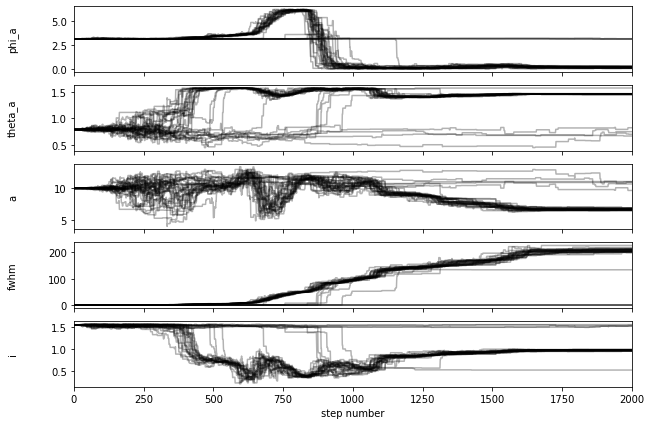

In [36]:
fig, axes = plt.subplots(5, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ['phi_a', 'theta_a', 'a', 'fwhm', 'i']
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");
plt.savefig("K2_sample_constrained_i_more.png",dpi=300)

(6400, 5)


Too few points to create valid contours
Too few points to create valid contours
Too few points to create valid contours
Too few points to create valid contours
Too few points to create valid contours
Too few points to create valid contours
Too few points to create valid contours
Too few points to create valid contours
Too few points to create valid contours
Too few points to create valid contours


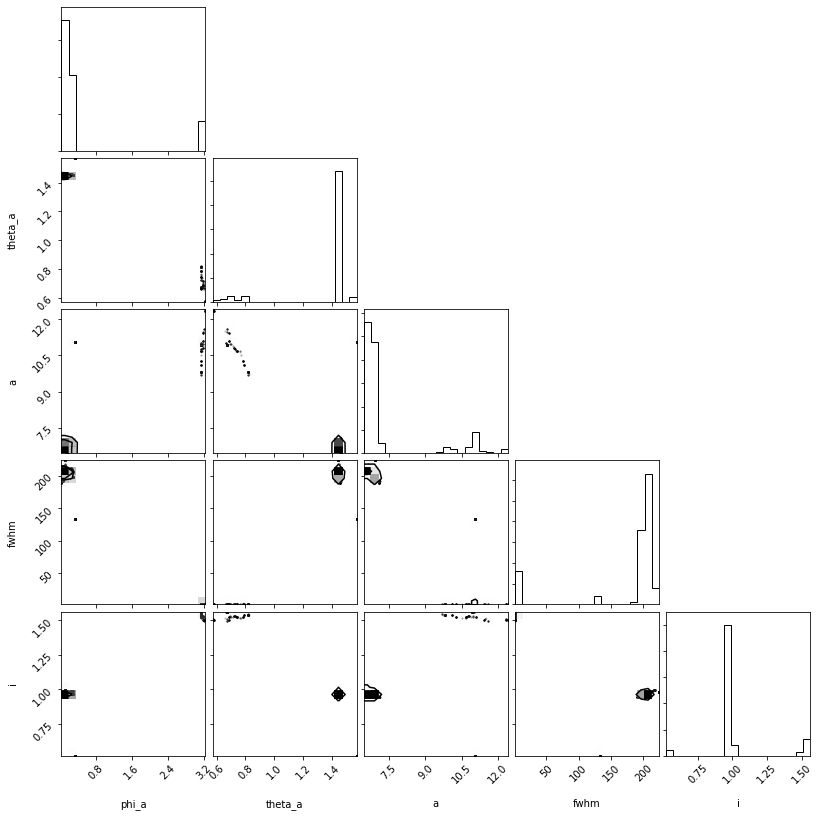

In [38]:
import corner
flat_samples = sampler.get_chain(discard=1800, flat=True)
print(flat_samples.shape)
fig = corner.corner(flat_samples, labels=labels,)# truths=[guess.t0, guess.dur, guess.ampl]);

In [47]:
sample[[0,3,2]]

array([1.37460570e-01, 2.10723424e+02, 6.50453560e+00])

No handles with labels found to put in legend.


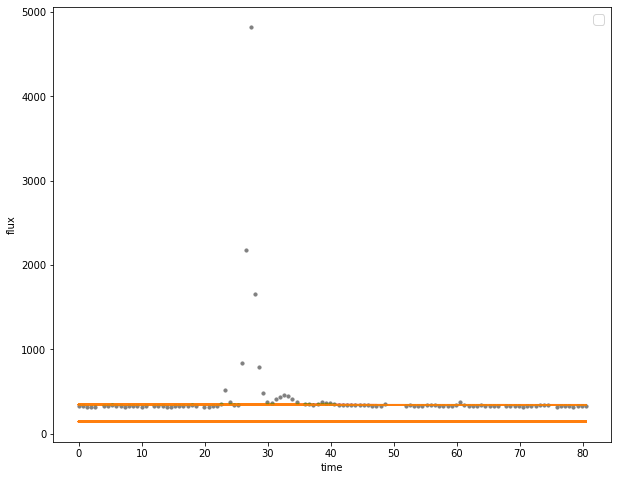

In [51]:
inds = np.random.randint(len(flat_samples), size=300)
plt.figure(figsize=(10,8))
#t_ = np.linspace(target.view_start, target.view_stop,800)
#plt.scatter(flck.time, flck.flux, s=1)
plt.scatter(phi, flux+200, s=10, c="grey")
#plt.errorbar(time, flux, yerr=flux_err, fmt=".k", capsize=0)

for ind in inds:
    sample = flat_samples[ind]
    plt.plot(phi, aflare2(phi, *sample[[0,3,2]], median), "C1", alpha=0.05)
    plt.plot(phi, aflare2(phi, *sample[[0,3,2]], median)+200, "C1", alpha=0.05)

#plt.plot(flc.time, truth, "k", label="init gues", linewidth=1)
plt.legend(fontsize=14)
#plt.xlim(10, 13)
plt.xlabel("time")
plt.ylabel("flux");
#plt.xlim(target.view_start, target.view_stop);
#plt.ylim(135,140)

In [0]:
samples = sampler.chain[:, 40:, :].reshape((-1, ndim))
#samples[:, 2] = np.exp(samples[:, 2])
t0_mcmc, dur_mcmc, ampl_mcmc = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]),
                             zip(*np.percentile(samples, [16, 50, 84],
                                                axis=0)))
t0_mcmc, dur_mcmc, ampl_mcmc

In [0]:
e_t0 = (t0_mcmc[1] + t0_mcmc[2])/2.
e_dur = (dur_mcmc[1] + dur_mcmc[2])/2.
e_ampl = (ampl_mcmc[1] + ampl_mcmc[2])/2.

In [0]:

def ED(t, t0, dur, ampl, median):
    x = t * 60.0 * 60.0 * 24.0
    return np.sum(np.diff(x) * aflare(t, t0, dur, ampl)[:-1]) / (dur * 6 * median)

In [0]:

def t0_ED(x):
    return ED(flc.time, x, dur_mcmc[0], ampl_mcmc[0], median)
def dur_ED(x):
    return ED(flc.time, t0_mcmc[0], x, ampl_mcmc[0], median)
def ampl_ED(x):
    return ED(flc.time, t0_mcmc[0], dur_mcmc[0], x, median)
def median_ED(x):
    return ED(flc.time, t0_mcmc[0], dur_mcmc[0], ampl_mcmc[0], x)
E_t0 = np.sum(derivative(t0_ED, t0_mcmc[0], dx=e_t0/10.)**2 * e_t0**2)
E_dur = np.sum(derivative(dur_ED, dur_mcmc[0], dx=e_dur/10.)**2 * e_dur**2)
E_ampl = np.sum(derivative(ampl_ED, ampl_mcmc[0], dx=e_ampl/10.)**2 * e_ampl**2)
E_median = np.sum(derivative(median_ED, median, dx=e_median/10.)**2 * e_median**2)
np.sqrt(E_t0 + E_dur + E_ampl + E_median), E_t0, E_dur, E_ampl, E_median

In [0]:
check_e_median = ED(flc.time, t0_mcmc[0], dur_mcmc[0], ampl_mcmc[0], median)**2 / median**2 * e_median**2
assert E_median == pytest.approx(E_median,rel=1e-4)
e_median, median

In [0]:
EDval = ED(flc.time, t0_mcmc[0], dur_mcmc[0], ampl_mcmc[0], median)
e_ED = np.sqrt(E_t0 + E_dur + E_ampl + E_median)
EDval,e_ED

In [0]:
with open(f"{CWD}/data/summary/results.csv", "a") as k:
    stri = (f"{target.prefix} {target.ID},{EDval:.0f},{e_ED:.0f},"\
            f"{t0_mcmc[0]:.5f},{e_t0:.5f},"\
            f"{dur_mcmc[0]*6:.5f},{e_dur*6:.5f},"\
            f"{ampl_mcmc[0]/median:.5f},{e_ampl/median:.5f}\n"\
            f"{period.value:.2f}")
   # stri = "ID,ED,e_ED,t0,e_t0,dur,e_dur,ampl,e_ampl,Prot_h\n"
    k.write(stri)